<a href="https://colab.research.google.com/github/varsha-282/CIP/blob/main/cipdemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

file_path = "Gestational DM.csv"
df = pd.read_csv(file_path)

label_encoded = df.copy()
label_encoded['Preterm Pregnancy'] = label_encoded['Preterm Pregnancy'].astype('category').cat.codes

print("Label Encoded 'Preterm Pregnancy' column:")
print(label_encoded['Preterm Pregnancy'])


Label Encoded 'Preterm Pregnancy' column:
0      1
1      0
2      1
3      0
4      1
      ..
194    1
195    0
196    1
197    1
198    1
Name: Preterm Pregnancy, Length: 199, dtype: int8


In [ ]:
def mean_imputation(df):
    column_means = df.mean()
    df_filled = df.fillna(column_means)
    return df_filled

df_imputed = mean_imputation(label_encoded)
changed_values = pd.concat([label_encoded[label_encoded != df_imputed].stack(), df_imputed[df_imputed != label_encoded].stack()], axis=1)
changed_values.columns = ['Original', 'Imputed']

print("Changed values before and after mean imputation:")
print(changed_values)

Changed values before and after mean imputation:
         Original    Imputed
10  BMI       NaN  21.991837
22  BMI       NaN  21.991837
130 BMI       NaN  21.991837


In [ ]:
preprocessed_file_path = "preprocessed_data.csv"
df_imputed.to_csv(preprocessed_file_path, index=False)
print(f"Preprocessed data saved to '{preprocessed_file_path}'")

Preprocessed data saved to 'preprocessed_data.csv'


In [ ]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.optimizers import Adam
latent_dim = 100
def build_generator():
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(2,))
    x = concatenate([noise, label])
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(12, activation='linear')(x)
    generator = Model([noise, label], x)
    return generator

def build_discriminator():
    data = Input(shape=(12,))
    x = Dense(256, activation='relu')(data)
    x = Dense(128, activation='relu')(x)
    validity = Dense(1, activation='sigmoid')(x)
    discriminator = Model(data, validity)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return discriminator

def build_combined(generator, discriminator):
    discriminator.trainable = False
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(2,))
    synthetic_data = generator([noise, label])
    validity = discriminator(synthetic_data)
    combined = Model([noise, label], validity)
    combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return combined

def train_discriminator(discriminator, real_data, synthetic_data):
    real_labels = np.ones((real_data.shape[0], 1))
    fake_labels = np.zeros((synthetic_data.shape[0], 1))
    discriminator.train_on_batch(real_data, real_labels)
    discriminator.train_on_batch(synthetic_data, fake_labels)

def train_generator(combined, noise, labels):
    valid_labels = np.ones((noise.shape[0], 1))
    combined.train_on_batch([noise, labels], valid_labels)

def generate_synthetic_data(generator, num_samples):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    labels = np.random.randint(0, 2, (num_samples, 2))
    synthetic_data = generator.predict([noise, labels])
    return synthetic_data

preprocessed_data = pd.read_csv('preprocessed_data.csv')

generator = build_generator()
discriminator = build_discriminator()
combined = build_combined(generator, discriminator)

num_epochs = 10000
batch_size = 128
for epoch in range(num_epochs):
    idx = np.random.randint(0, preprocessed_data.shape[0], batch_size)
    real_batch = preprocessed_data.iloc[idx]
    synthetic_batch = generate_synthetic_data(generator, batch_size)
    train_discriminator(discriminator, real_batch, synthetic_batch)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    labels = np.random.randint(0, 2, (batch_size, 2))
    train_generator(combined, noise, labels)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}")

num_samples = 5000
synthetic_data = generate_synthetic_data(generator, num_samples)
synthetic_df = pd.DataFrame(synthetic_data, columns=preprocessed_data.columns)
synthetic_df.to_csv('synthetic_data.csv', index=False)


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 3ms/step
Epoch 5100/10000
4/4 [==============================] - 0s 5ms/step
Epoch 5200/10000
4/4 [==============================] - 0s 3ms/step
Epoch 5300/10000
4/4 [==============================] - 0s 3ms/step
Epoch 5400/10000
4/4 [==============================] - 0s 4ms/step
Epoch 5500/10000
4/4 [==============================] - 0s 3ms/step
Epoch 5600/10000
4/4 [==============================] - 0s 7ms/step
Epoch 5700/10000
4/4 [==============================] - 0s 4ms/step
Epoch 5800/10000
4/4 [==============================] - 0s 3ms/step
Epoch 5900/10000
4/4 [==============================] - 0s 3ms/step
Epoch 6000/10000
4/4 [==============================] - 0s 4ms/step
Epoch 6100/10000
4/4 [==============================] - 0s 4ms/step
Epoch 6200/10000
4/4 [==============================] - 0s 4ms/step
Epoch 6300/10000
4/4 [==============================] - 0s 3ms/step
Epoch 6400/100

In [ ]:
synthetic_data = pd.read_csv('synthetic_data.csv')
columns_to_round = ['Age', 'No of Pregnancy', 'Preterm Pregnancy', 'Systolic Blood Pressure', 'Diastolic Blood Pressure']
synthetic_data.columns = synthetic_data.columns.str.strip()
synthetic_data[columns_to_round] = synthetic_data[columns_to_round].round()
synthetic_data['Preterm Pregnancy'] = synthetic_data['Preterm Pregnancy'].apply(lambda x: 1 if x > 0.5 else 0)
synthetic_data.to_csv('synthetic_data_rounded.csv', index=False)


In [ ]:
preprocessed_data = pd.read_csv('synthetic_data_rounded.csv')
preterm_pregnancy_counts = preprocessed_data['Preterm Pregnancy'].value_counts()

print("Counts of 1's and 0's in 'Preterm Pregnancy' column:")
print(preterm_pregnancy_counts)


Counts of 1's and 0's in 'Preterm Pregnancy' column:
Preterm Pregnancy
1    4057
0     943
Name: count, dtype: int64


In [ ]:
import pandas as pd
from imblearn.over_sampling import ADASYN
data = pd.read_csv('synthetic_data_rounded.csv')

feature_columns = ['Age', 'No of Pregnancy', 'BMI', 'Systolic Blood Pressure', 'Diastolic Blood Pressure',
                   'Bloodc Sugar Fasting', 'Blood Sugar Post Prandial', 'Oral Gucose tolerance test',
                   'C-Reactive Protein', 'Interleukin 6-IL 6', 'Birth weight']
target_column = 'Preterm Pregnancy'  # Replace 'Target' with the name of your target column
X = data[feature_columns]
y = data[target_column]
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)
balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=feature_columns),
                           pd.DataFrame(y_resampled, columns=[target_column])], axis=1)
balanced_data.to_csv('balanced_dataset.csv', index=False)



In [ ]:
preprocessed_data = pd.read_csv('balanced_dataset.csv')
preterm_pregnancy_counts = preprocessed_data['Preterm Pregnancy'].value_counts()

print("Counts of 1's and 0's in 'Preterm Pregnancy' column:")
print(preterm_pregnancy_counts)


Counts of 1's and 0's in 'Preterm Pregnancy' column:
Preterm Pregnancy
1    4057
0    3987
Name: count, dtype: int64


In [2]:
pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [3]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('balanced_dataset.csv')

X = data.drop(columns=['Preterm Pregnancy'])
y = data['Preterm Pregnancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 0.1, 2.0),
        "momentum": trial.suggest_float("momentum", 0.01, 0.5),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 0.0001, 0.1),
        "optimizer_params": {
            "lr": trial.suggest_float("lr", 1e-4, 1e-1, log=True),
            "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True),
        },
    }

    model = TabNetClassifier(**params)
    model.fit(X_train.values, y_train.values, eval_set=[(X_test.values, y_test.values)], patience=10, max_epochs=100,
              batch_size=128, virtual_batch_size=32, num_workers=0, drop_last=False)

    y_pred_proba = model.predict_proba(X_test.values)
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    return auc

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best parameters:", best_params)

best_auc = study.best_value
print("Best AUC:", best_auc)


[I 2024-05-05 04:45:05,450] A new study created in memory with name: no-name-0085f994-023a-4414-9c55-e1983f37cb0f
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7577  | val_0_auc: 0.67977 |  0:00:08s
epoch 1  | loss: 0.54169 | val_0_auc: 0.83977 |  0:00:15s
epoch 2  | loss: 0.52434 | val_0_auc: 0.83535 |  0:00:22s
epoch 3  | loss: 0.49774 | val_0_auc: 0.77548 |  0:00:26s
epoch 4  | loss: 0.48592 | val_0_auc: 0.88979 |  0:00:29s
epoch 5  | loss: 0.49551 | val_0_auc: 0.89579 |  0:00:33s
epoch 6  | loss: 0.47728 | val_0_auc: 0.89871 |  0:00:36s
epoch 7  | loss: 0.46809 | val_0_auc: 0.908   |  0:00:40s
epoch 8  | loss: 0.46702 | val_0_auc: 0.85618 |  0:00:43s
epoch 9  | loss: 0.49165 | val_0_auc: 0.80168 |  0:00:47s
epoch 10 | loss: 0.46796 | val_0_auc: 0.88859 |  0:00:50s
epoch 11 | loss: 0.48174 | val_0_auc: 0.84781 |  0:00:53s
epoch 12 | loss: 0.46541 | val_0_auc: 0.85728 |  0:00:57s
epoch 13 | loss: 0.45937 | val_0_auc: 0.8993  |  0:01:01s
epoch 14 | loss: 0.45017 | val_0_auc: 0.90948 |  0:01:04s
epoch 15 | loss: 0.45668 | val_0_auc: 0.90143 |  0:01:07s
epoch 16 | loss: 0.46642 | val_0_auc: 0.88664 |  0:01:11s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 04:47:07,261] Trial 0 finished with value: 0.920351000828357 and parameters: {'n_d': 17, 'n_a': 59, 'n_steps': 6, 'gamma': 0.5367163232180874, 'momentum': 0.05693366071755578, 'lambda_sparse': 0.04371467545266993, 'lr': 0.08584618631417748, 'weight_decay': 0.0008902198258361513}. Best is trial 0 with value: 0.920351000828357.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68272 | val_0_auc: 0.52481 |  0:00:05s
epoch 1  | loss: 0.46163 | val_0_auc: 0.69249 |  0:00:09s
epoch 2  | loss: 0.4451  | val_0_auc: 0.82214 |  0:00:15s
epoch 3  | loss: 0.39639 | val_0_auc: 0.90698 |  0:00:20s
epoch 4  | loss: 0.38478 | val_0_auc: 0.92561 |  0:00:25s
epoch 5  | loss: 0.39239 | val_0_auc: 0.93251 |  0:00:29s
epoch 6  | loss: 0.36299 | val_0_auc: 0.93635 |  0:00:34s
epoch 7  | loss: 0.35263 | val_0_auc: 0.92889 |  0:00:39s
epoch 8  | loss: 0.34972 | val_0_auc: 0.94242 |  0:00:43s
epoch 9  | loss: 0.33491 | val_0_auc: 0.93004 |  0:00:48s
epoch 10 | loss: 0.3436  | val_0_auc: 0.9385  |  0:00:53s
epoch 11 | loss: 0.34194 | val_0_auc: 0.95213 |  0:00:58s
epoch 12 | loss: 0.32909 | val_0_auc: 0.95126 |  0:01:02s
epoch 13 | loss: 0.32333 | val_0_auc: 0.94793 |  0:01:06s
epoch 14 | loss: 0.32717 | val_0_auc: 0.94628 |  0:01:11s
epoch 15 | loss: 0.33118 | val_0_auc: 0.94802 |  0:01:15s
epoch 16 | loss: 0.32967 | val_0_auc: 0.95182 |  0:01:20s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 04:49:34,472] Trial 1 finished with value: 0.9555159922356984 and parameters: {'n_d': 46, 'n_a': 55, 'n_steps': 7, 'gamma': 0.37811161026892715, 'momentum': 0.4792089037356367, 'lambda_sparse': 0.01117727577406137, 'lr': 0.003241166799524568, 'weight_decay': 0.00045689069086874296}. Best is trial 1 with value: 0.9555159922356984.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77579 | val_0_auc: 0.51721 |  0:00:03s
epoch 1  | loss: 0.46851 | val_0_auc: 0.71302 |  0:00:07s
epoch 2  | loss: 0.42767 | val_0_auc: 0.87682 |  0:00:11s
epoch 3  | loss: 0.40646 | val_0_auc: 0.89602 |  0:00:15s
epoch 4  | loss: 0.40544 | val_0_auc: 0.92115 |  0:00:19s
epoch 5  | loss: 0.38833 | val_0_auc: 0.93316 |  0:00:23s
epoch 6  | loss: 0.38496 | val_0_auc: 0.93485 |  0:00:26s
epoch 7  | loss: 0.38647 | val_0_auc: 0.93446 |  0:00:31s
epoch 8  | loss: 0.38505 | val_0_auc: 0.93279 |  0:00:35s
epoch 9  | loss: 0.37689 | val_0_auc: 0.93026 |  0:00:39s
epoch 10 | loss: 0.3709  | val_0_auc: 0.92267 |  0:00:44s
epoch 11 | loss: 0.3685  | val_0_auc: 0.93704 |  0:00:47s
epoch 12 | loss: 0.3701  | val_0_auc: 0.93984 |  0:00:51s
epoch 13 | loss: 0.37643 | val_0_auc: 0.935   |  0:00:55s
epoch 14 | loss: 0.37254 | val_0_auc: 0.933   |  0:00:59s
epoch 15 | loss: 0.36426 | val_0_auc: 0.92933 |  0:01:02s
epoch 16 | loss: 0.36107 | val_0_auc: 0.93448 |  0:01:06s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 04:52:33,708] Trial 2 finished with value: 0.9486434108527132 and parameters: {'n_d': 19, 'n_a': 49, 'n_steps': 7, 'gamma': 0.5865103220838861, 'momentum': 0.3516857262512758, 'lambda_sparse': 0.011188998376822428, 'lr': 0.01126369603307391, 'weight_decay': 0.0008326413214649438}. Best is trial 1 with value: 0.9555159922356984.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81694 | val_0_auc: 0.51246 |  0:00:02s
epoch 1  | loss: 0.62596 | val_0_auc: 0.65835 |  0:00:04s
epoch 2  | loss: 0.60841 | val_0_auc: 0.70743 |  0:00:07s
epoch 3  | loss: 0.58736 | val_0_auc: 0.76528 |  0:00:10s
epoch 4  | loss: 0.56708 | val_0_auc: 0.786   |  0:00:14s
epoch 5  | loss: 0.56281 | val_0_auc: 0.82754 |  0:00:16s
epoch 6  | loss: 0.53221 | val_0_auc: 0.81989 |  0:00:18s
epoch 7  | loss: 0.53294 | val_0_auc: 0.8445  |  0:00:21s
epoch 8  | loss: 0.48766 | val_0_auc: 0.84777 |  0:00:23s
epoch 9  | loss: 0.46658 | val_0_auc: 0.88421 |  0:00:25s
epoch 10 | loss: 0.4466  | val_0_auc: 0.90782 |  0:00:28s
epoch 11 | loss: 0.4149  | val_0_auc: 0.89982 |  0:00:30s
epoch 12 | loss: 0.41715 | val_0_auc: 0.89914 |  0:00:32s
epoch 13 | loss: 0.42793 | val_0_auc: 0.90266 |  0:00:38s
epoch 14 | loss: 0.40764 | val_0_auc: 0.92096 |  0:00:44s
epoch 15 | loss: 0.38109 | val_0_auc: 0.93005 |  0:00:46s
epoch 16 | loss: 0.38469 | val_0_auc: 0.91864 |  0:00:48s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 04:56:24,998] Trial 3 finished with value: 0.9627007529394311 and parameters: {'n_d': 64, 'n_a': 47, 'n_steps': 3, 'gamma': 0.9745489339831573, 'momentum': 0.48773071153483066, 'lambda_sparse': 0.059996002307291275, 'lr': 0.05527460060984675, 'weight_decay': 1.575484066176723e-06}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.05948 | val_0_auc: 0.44571 |  0:00:03s
epoch 1  | loss: 0.75783 | val_0_auc: 0.59086 |  0:00:07s
epoch 2  | loss: 0.69219 | val_0_auc: 0.61741 |  0:00:11s
epoch 3  | loss: 0.6431  | val_0_auc: 0.69669 |  0:00:15s
epoch 4  | loss: 0.63425 | val_0_auc: 0.71556 |  0:00:20s
epoch 5  | loss: 0.6246  | val_0_auc: 0.74105 |  0:00:25s
epoch 6  | loss: 0.61166 | val_0_auc: 0.76799 |  0:00:29s
epoch 7  | loss: 0.60175 | val_0_auc: 0.77898 |  0:00:33s
epoch 8  | loss: 0.59476 | val_0_auc: 0.78117 |  0:00:37s
epoch 9  | loss: 0.59631 | val_0_auc: 0.78483 |  0:00:41s
epoch 10 | loss: 0.58886 | val_0_auc: 0.79792 |  0:00:45s
epoch 11 | loss: 0.56386 | val_0_auc: 0.79851 |  0:00:49s
epoch 12 | loss: 0.5554  | val_0_auc: 0.79565 |  0:00:53s
epoch 13 | loss: 0.5637  | val_0_auc: 0.799   |  0:00:57s
epoch 14 | loss: 0.54188 | val_0_auc: 0.81499 |  0:01:02s
epoch 15 | loss: 0.54442 | val_0_auc: 0.82243 |  0:01:06s
epoch 16 | loss: 0.5386  | val_0_auc: 0.81738 |  0:01:10s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:04:00,005] Trial 4 finished with value: 0.9502352163000879 and parameters: {'n_d': 9, 'n_a': 19, 'n_steps': 9, 'gamma': 1.7661493987258048, 'momentum': 0.015857209761141466, 'lambda_sparse': 0.011092664901716764, 'lr': 0.005985068451656573, 'weight_decay': 0.0005484719541373167}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.24978 | val_0_auc: 0.41139 |  0:00:04s
epoch 1  | loss: 2.80263 | val_0_auc: 0.45895 |  0:00:10s
epoch 2  | loss: 2.30382 | val_0_auc: 0.52582 |  0:00:15s
epoch 3  | loss: 1.8864  | val_0_auc: 0.56906 |  0:00:22s
epoch 4  | loss: 1.49586 | val_0_auc: 0.60865 |  0:00:27s
epoch 5  | loss: 1.23531 | val_0_auc: 0.63917 |  0:00:33s
epoch 6  | loss: 1.07107 | val_0_auc: 0.6561  |  0:00:39s
epoch 7  | loss: 0.97751 | val_0_auc: 0.67728 |  0:00:45s
epoch 8  | loss: 0.91446 | val_0_auc: 0.70443 |  0:00:50s
epoch 9  | loss: 0.86897 | val_0_auc: 0.71823 |  0:00:55s
epoch 10 | loss: 0.81867 | val_0_auc: 0.73795 |  0:01:01s
epoch 11 | loss: 0.80618 | val_0_auc: 0.74612 |  0:01:06s
epoch 12 | loss: 0.79078 | val_0_auc: 0.76245 |  0:01:12s
epoch 13 | loss: 0.78581 | val_0_auc: 0.77184 |  0:01:17s
epoch 14 | loss: 0.77334 | val_0_auc: 0.77976 |  0:01:23s
epoch 15 | loss: 0.75587 | val_0_auc: 0.79514 |  0:01:28s
epoch 16 | loss: 0.73268 | val_0_auc: 0.79244 |  0:01:33s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:13:11,374] Trial 5 finished with value: 0.927436853232447 and parameters: {'n_d': 16, 'n_a': 55, 'n_steps': 10, 'gamma': 0.6150212192252065, 'momentum': 0.020010526379273474, 'lambda_sparse': 0.05494999004531719, 'lr': 0.00010580397815268968, 'weight_decay': 2.614650057694774e-06}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35358 | val_0_auc: 0.52413 |  0:00:03s
epoch 1  | loss: 1.09474 | val_0_auc: 0.55512 |  0:00:06s
epoch 2  | loss: 0.91883 | val_0_auc: 0.52337 |  0:00:09s
epoch 3  | loss: 0.86458 | val_0_auc: 0.60387 |  0:00:12s
epoch 4  | loss: 0.79667 | val_0_auc: 0.60159 |  0:00:15s
epoch 5  | loss: 0.77059 | val_0_auc: 0.65645 |  0:00:20s
epoch 6  | loss: 0.76045 | val_0_auc: 0.65576 |  0:00:26s
epoch 7  | loss: 0.73988 | val_0_auc: 0.6974  |  0:00:29s
epoch 8  | loss: 0.71954 | val_0_auc: 0.72223 |  0:00:33s
epoch 9  | loss: 0.69355 | val_0_auc: 0.72374 |  0:00:36s
epoch 10 | loss: 0.68478 | val_0_auc: 0.73396 |  0:00:39s
epoch 11 | loss: 0.68019 | val_0_auc: 0.74726 |  0:00:42s
epoch 12 | loss: 0.65373 | val_0_auc: 0.73702 |  0:00:45s
epoch 13 | loss: 0.64362 | val_0_auc: 0.76417 |  0:00:48s
epoch 14 | loss: 0.6434  | val_0_auc: 0.76662 |  0:00:51s
epoch 15 | loss: 0.62613 | val_0_auc: 0.76784 |  0:00:55s
epoch 16 | loss: 0.6318  | val_0_auc: 0.78794 |  0:00:58s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:18:47,713] Trial 6 finished with value: 0.9143685941421559 and parameters: {'n_d': 27, 'n_a': 52, 'n_steps': 5, 'gamma': 1.2349934593986374, 'momentum': 0.27733172709447024, 'lambda_sparse': 0.02838059290585973, 'lr': 0.0004444542349001473, 'weight_decay': 4.458601838917823e-06}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.27701 | val_0_auc: 0.65486 |  0:00:06s
epoch 1  | loss: 0.5216  | val_0_auc: 0.80911 |  0:00:12s
epoch 2  | loss: 0.4681  | val_0_auc: 0.89989 |  0:00:18s
epoch 3  | loss: 0.45635 | val_0_auc: 0.9312  |  0:00:25s
epoch 4  | loss: 0.43496 | val_0_auc: 0.93806 |  0:00:32s
epoch 5  | loss: 0.41855 | val_0_auc: 0.93334 |  0:00:39s
epoch 6  | loss: 0.4134  | val_0_auc: 0.94627 |  0:00:46s
epoch 7  | loss: 0.41688 | val_0_auc: 0.94178 |  0:00:53s
epoch 8  | loss: 0.39803 | val_0_auc: 0.95201 |  0:01:00s
epoch 9  | loss: 0.39695 | val_0_auc: 0.95433 |  0:01:06s
epoch 10 | loss: 0.40355 | val_0_auc: 0.94411 |  0:01:13s
epoch 11 | loss: 0.39019 | val_0_auc: 0.94147 |  0:01:19s
epoch 12 | loss: 0.38451 | val_0_auc: 0.94935 |  0:01:26s
epoch 13 | loss: 0.38286 | val_0_auc: 0.9493  |  0:01:32s
epoch 14 | loss: 0.37747 | val_0_auc: 0.95484 |  0:01:39s
epoch 15 | loss: 0.35761 | val_0_auc: 0.94485 |  0:01:45s
epoch 16 | loss: 0.37471 | val_0_auc: 0.9514  |  0:01:53s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:22:02,568] Trial 7 finished with value: 0.960408862183648 and parameters: {'n_d': 54, 'n_a': 63, 'n_steps': 10, 'gamma': 0.5356732286723528, 'momentum': 0.2861220168804916, 'lambda_sparse': 0.055660765574187296, 'lr': 0.0400624876216833, 'weight_decay': 1.7562852811080303e-06}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.20822 | val_0_auc: 0.5109  |  0:00:05s
epoch 1  | loss: 3.10958 | val_0_auc: 0.55036 |  0:00:09s
epoch 2  | loss: 2.09789 | val_0_auc: 0.58146 |  0:00:13s
epoch 3  | loss: 1.3376  | val_0_auc: 0.68732 |  0:00:18s
epoch 4  | loss: 0.85297 | val_0_auc: 0.75195 |  0:00:23s
epoch 5  | loss: 0.66976 | val_0_auc: 0.78983 |  0:00:28s
epoch 6  | loss: 0.60382 | val_0_auc: 0.81029 |  0:00:32s
epoch 7  | loss: 0.57606 | val_0_auc: 0.82572 |  0:00:36s
epoch 8  | loss: 0.55982 | val_0_auc: 0.84418 |  0:00:42s
epoch 9  | loss: 0.5376  | val_0_auc: 0.84628 |  0:00:46s
epoch 10 | loss: 0.53713 | val_0_auc: 0.86245 |  0:00:51s
epoch 11 | loss: 0.52582 | val_0_auc: 0.84168 |  0:00:55s
epoch 12 | loss: 0.50001 | val_0_auc: 0.86588 |  0:01:00s
epoch 13 | loss: 0.50622 | val_0_auc: 0.8673  |  0:01:05s
epoch 14 | loss: 0.4962  | val_0_auc: 0.8578  |  0:01:10s
epoch 15 | loss: 0.49251 | val_0_auc: 0.87724 |  0:01:14s
epoch 16 | loss: 0.47779 | val_0_auc: 0.87132 |  0:01:19s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:29:06,015] Trial 8 finished with value: 0.9445433527440872 and parameters: {'n_d': 28, 'n_a': 18, 'n_steps': 9, 'gamma': 0.3930845189108897, 'momentum': 0.3183755471752994, 'lambda_sparse': 0.002444965496372508, 'lr': 0.00016027281285483437, 'weight_decay': 0.00037035960583629916}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79612 | val_0_auc: 0.53913 |  0:00:02s
epoch 1  | loss: 0.59668 | val_0_auc: 0.69465 |  0:00:05s
epoch 2  | loss: 0.5442  | val_0_auc: 0.83857 |  0:00:07s
epoch 3  | loss: 0.5487  | val_0_auc: 0.86146 |  0:00:10s
epoch 4  | loss: 0.48513 | val_0_auc: 0.88367 |  0:00:12s
epoch 5  | loss: 0.46941 | val_0_auc: 0.87904 |  0:00:15s
epoch 6  | loss: 0.4605  | val_0_auc: 0.88777 |  0:00:18s
epoch 7  | loss: 0.44068 | val_0_auc: 0.88692 |  0:00:20s
epoch 8  | loss: 0.42825 | val_0_auc: 0.91737 |  0:00:22s
epoch 9  | loss: 0.41226 | val_0_auc: 0.91331 |  0:00:24s
epoch 10 | loss: 0.40374 | val_0_auc: 0.92145 |  0:00:27s
epoch 11 | loss: 0.40568 | val_0_auc: 0.91691 |  0:00:30s
epoch 12 | loss: 0.40559 | val_0_auc: 0.9365  |  0:00:32s
epoch 13 | loss: 0.37616 | val_0_auc: 0.9248  |  0:00:34s
epoch 14 | loss: 0.36881 | val_0_auc: 0.91985 |  0:00:37s
epoch 15 | loss: 0.39707 | val_0_auc: 0.93369 |  0:00:39s
epoch 16 | loss: 0.39774 | val_0_auc: 0.92402 |  0:00:42s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:33:26,716] Trial 9 finished with value: 0.9592520987104831 and parameters: {'n_d': 60, 'n_a': 64, 'n_steps': 3, 'gamma': 1.7750255929062788, 'momentum': 0.32944511553135714, 'lambda_sparse': 0.07392840590413517, 'lr': 0.017435889503129506, 'weight_decay': 4.800105390377957e-06}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84351 | val_0_auc: 0.5227  |  0:00:02s
epoch 1  | loss: 0.74044 | val_0_auc: 0.5591  |  0:00:05s
epoch 2  | loss: 0.71684 | val_0_auc: 0.64408 |  0:00:07s
epoch 3  | loss: 0.67874 | val_0_auc: 0.67988 |  0:00:09s
epoch 4  | loss: 0.65104 | val_0_auc: 0.75061 |  0:00:11s
epoch 5  | loss: 0.62658 | val_0_auc: 0.79178 |  0:00:13s
epoch 6  | loss: 0.6067  | val_0_auc: 0.81543 |  0:00:16s
epoch 7  | loss: 0.58477 | val_0_auc: 0.83676 |  0:00:18s
epoch 8  | loss: 0.56077 | val_0_auc: 0.83692 |  0:00:21s
epoch 9  | loss: 0.54868 | val_0_auc: 0.84531 |  0:00:23s
epoch 10 | loss: 0.54694 | val_0_auc: 0.81094 |  0:00:25s
epoch 11 | loss: 0.54017 | val_0_auc: 0.85431 |  0:00:28s
epoch 12 | loss: 0.52181 | val_0_auc: 0.87266 |  0:00:30s
epoch 13 | loss: 0.50855 | val_0_auc: 0.85838 |  0:00:33s
epoch 14 | loss: 0.50658 | val_0_auc: 0.86302 |  0:00:35s
epoch 15 | loss: 0.49879 | val_0_auc: 0.87152 |  0:00:37s
epoch 16 | loss: 0.49939 | val_0_auc: 0.88584 |  0:00:39s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:37:51,081] Trial 10 finished with value: 0.9458940692110827 and parameters: {'n_d': 64, 'n_a': 37, 'n_steps': 3, 'gamma': 1.2567704601948433, 'momentum': 0.49053814904449045, 'lambda_sparse': 0.09363897415427358, 'lr': 0.0010608386677375505, 'weight_decay': 2.4778819807607405e-05}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90782 | val_0_auc: 0.57371 |  0:00:03s
epoch 1  | loss: 0.64527 | val_0_auc: 0.64524 |  0:00:06s
epoch 2  | loss: 0.62419 | val_0_auc: 0.77477 |  0:00:09s
epoch 3  | loss: 0.60394 | val_0_auc: 0.78959 |  0:00:12s
epoch 4  | loss: 0.59255 | val_0_auc: 0.77682 |  0:00:16s
epoch 5  | loss: 0.57641 | val_0_auc: 0.78206 |  0:00:19s
epoch 6  | loss: 0.58671 | val_0_auc: 0.79919 |  0:00:22s
epoch 7  | loss: 0.57385 | val_0_auc: 0.80503 |  0:00:26s
epoch 8  | loss: 0.57077 | val_0_auc: 0.81136 |  0:00:28s
epoch 9  | loss: 0.56381 | val_0_auc: 0.82048 |  0:00:31s
epoch 10 | loss: 0.55644 | val_0_auc: 0.82452 |  0:00:34s
epoch 11 | loss: 0.56165 | val_0_auc: 0.79653 |  0:00:38s
epoch 12 | loss: 0.57355 | val_0_auc: 0.82123 |  0:00:41s
epoch 13 | loss: 0.55282 | val_0_auc: 0.81315 |  0:00:44s
epoch 14 | loss: 0.54769 | val_0_auc: 0.82765 |  0:00:47s
epoch 15 | loss: 0.54103 | val_0_auc: 0.84016 |  0:00:50s
epoch 16 | loss: 0.53217 | val_0_auc: 0.77919 |  0:00:54s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:40:29,364] Trial 11 finished with value: 0.8546047995252402 and parameters: {'n_d': 48, 'n_a': 40, 'n_steps': 5, 'gamma': 0.9005273622065978, 'momentum': 0.17551312516100676, 'lambda_sparse': 0.06158501991693404, 'lr': 0.06529962394606435, 'weight_decay': 1.1446444215438385e-06}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93845 | val_0_auc: 0.64537 |  0:00:05s
epoch 1  | loss: 0.55001 | val_0_auc: 0.84436 |  0:00:10s
epoch 2  | loss: 0.50473 | val_0_auc: 0.9185  |  0:00:15s
epoch 3  | loss: 0.47584 | val_0_auc: 0.92514 |  0:00:20s
epoch 4  | loss: 0.45246 | val_0_auc: 0.93667 |  0:00:25s
epoch 5  | loss: 0.4572  | val_0_auc: 0.93381 |  0:00:31s
epoch 6  | loss: 0.4386  | val_0_auc: 0.94688 |  0:00:35s
epoch 7  | loss: 0.43228 | val_0_auc: 0.93268 |  0:00:40s
epoch 8  | loss: 0.42095 | val_0_auc: 0.93187 |  0:00:47s
epoch 9  | loss: 0.41466 | val_0_auc: 0.94287 |  0:00:51s
epoch 10 | loss: 0.40741 | val_0_auc: 0.9343  |  0:00:57s
epoch 11 | loss: 0.41624 | val_0_auc: 0.94871 |  0:01:02s
epoch 12 | loss: 0.41373 | val_0_auc: 0.94468 |  0:01:07s
epoch 13 | loss: 0.40408 | val_0_auc: 0.94474 |  0:01:12s
epoch 14 | loss: 0.41113 | val_0_auc: 0.94588 |  0:01:17s
epoch 15 | loss: 0.37465 | val_0_auc: 0.95597 |  0:01:22s
epoch 16 | loss: 0.395   | val_0_auc: 0.94245 |  0:01:27s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:43:06,189] Trial 12 finished with value: 0.9577105201340207 and parameters: {'n_d': 53, 'n_a': 44, 'n_steps': 8, 'gamma': 0.14565248402286335, 'momentum': 0.4083464097642313, 'lambda_sparse': 0.07880962509100795, 'lr': 0.028690877422704295, 'weight_decay': 1.4206666505548226e-05}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77445 | val_0_auc: 0.52108 |  0:00:02s
epoch 1  | loss: 0.61952 | val_0_auc: 0.64221 |  0:00:05s
epoch 2  | loss: 0.57191 | val_0_auc: 0.73156 |  0:00:07s
epoch 3  | loss: 0.54679 | val_0_auc: 0.81428 |  0:00:11s
epoch 4  | loss: 0.52425 | val_0_auc: 0.8377  |  0:00:14s
epoch 5  | loss: 0.53055 | val_0_auc: 0.84466 |  0:00:16s
epoch 6  | loss: 0.52373 | val_0_auc: 0.84594 |  0:00:19s
epoch 7  | loss: 0.51998 | val_0_auc: 0.87948 |  0:00:22s
epoch 8  | loss: 0.47375 | val_0_auc: 0.89729 |  0:00:24s
epoch 9  | loss: 0.47268 | val_0_auc: 0.87517 |  0:00:27s
epoch 10 | loss: 0.4786  | val_0_auc: 0.82587 |  0:00:29s
epoch 11 | loss: 0.48734 | val_0_auc: 0.89469 |  0:00:32s
epoch 12 | loss: 0.47029 | val_0_auc: 0.85831 |  0:00:35s
epoch 13 | loss: 0.48118 | val_0_auc: 0.88885 |  0:00:37s
epoch 14 | loss: 0.47917 | val_0_auc: 0.85232 |  0:00:39s
epoch 15 | loss: 0.48886 | val_0_auc: 0.87177 |  0:00:42s
epoch 16 | loss: 0.45897 | val_0_auc: 0.91025 |  0:00:44s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:44:44,861] Trial 13 finished with value: 0.9377001347625582 and parameters: {'n_d': 40, 'n_a': 27, 'n_steps': 4, 'gamma': 0.9144812252970839, 'momentum': 0.18718480297333834, 'lambda_sparse': 0.04297026680808199, 'lr': 0.0328321540944076, 'weight_decay': 1.0187413604070002e-06}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44552 | val_0_auc: 0.55926 |  0:00:05s
epoch 1  | loss: 0.64851 | val_0_auc: 0.59838 |  0:00:12s
epoch 2  | loss: 0.65788 | val_0_auc: 0.64203 |  0:00:18s
epoch 3  | loss: 0.64709 | val_0_auc: 0.63107 |  0:00:25s
epoch 4  | loss: 0.63687 | val_0_auc: 0.71747 |  0:00:31s
epoch 5  | loss: 0.6244  | val_0_auc: 0.73139 |  0:00:39s
epoch 6  | loss: 0.61158 | val_0_auc: 0.72243 |  0:00:45s
epoch 7  | loss: 0.64248 | val_0_auc: 0.70777 |  0:00:50s
epoch 8  | loss: 0.62848 | val_0_auc: 0.72353 |  0:00:56s
epoch 9  | loss: 0.6449  | val_0_auc: 0.75163 |  0:01:02s
epoch 10 | loss: 0.62581 | val_0_auc: 0.73794 |  0:01:08s
epoch 11 | loss: 0.616   | val_0_auc: 0.77047 |  0:01:14s
epoch 12 | loss: 0.59807 | val_0_auc: 0.75505 |  0:01:20s
epoch 13 | loss: 0.59867 | val_0_auc: 0.76493 |  0:01:26s
epoch 14 | loss: 0.60033 | val_0_auc: 0.47469 |  0:01:33s
epoch 15 | loss: 0.59168 | val_0_auc: 0.7958  |  0:01:39s
epoch 16 | loss: 0.56987 | val_0_auc: 0.76725 |  0:01:44s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:51:53,670] Trial 14 finished with value: 0.9171333902056055 and parameters: {'n_d': 56, 'n_a': 30, 'n_steps': 10, 'gamma': 1.410612533819618, 'momentum': 0.4121043796363292, 'lambda_sparse': 0.06620884748189071, 'lr': 0.09686718778642563, 'weight_decay': 7.687874094297746e-05}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92359 | val_0_auc: 0.54085 |  0:00:04s
epoch 1  | loss: 0.70329 | val_0_auc: 0.59923 |  0:00:09s
epoch 2  | loss: 0.59037 | val_0_auc: 0.76623 |  0:00:13s
epoch 3  | loss: 0.56553 | val_0_auc: 0.80334 |  0:00:18s
epoch 4  | loss: 0.53998 | val_0_auc: 0.84466 |  0:00:23s
epoch 5  | loss: 0.52207 | val_0_auc: 0.85825 |  0:00:28s
epoch 6  | loss: 0.51797 | val_0_auc: 0.8822  |  0:00:33s
epoch 7  | loss: 0.51176 | val_0_auc: 0.88067 |  0:00:38s
epoch 8  | loss: 0.49009 | val_0_auc: 0.90048 |  0:00:42s
epoch 9  | loss: 0.47402 | val_0_auc: 0.90199 |  0:00:47s
epoch 10 | loss: 0.46756 | val_0_auc: 0.90957 |  0:00:51s
epoch 11 | loss: 0.46257 | val_0_auc: 0.89901 |  0:00:55s
epoch 12 | loss: 0.44925 | val_0_auc: 0.91443 |  0:01:00s
epoch 13 | loss: 0.43821 | val_0_auc: 0.91751 |  0:01:04s
epoch 14 | loss: 0.43111 | val_0_auc: 0.91286 |  0:01:08s
epoch 15 | loss: 0.44252 | val_0_auc: 0.91985 |  0:01:13s
epoch 16 | loss: 0.42214 | val_0_auc: 0.91486 |  0:01:18s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 05:56:25,627] Trial 15 finished with value: 0.949893673577884 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 6, 'gamma': 0.8379813976316084, 'momentum': 0.18063194043050526, 'lambda_sparse': 0.03619986084432182, 'lr': 0.008548637768392582, 'weight_decay': 1.1627199371441654e-05}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09256 | val_0_auc: 0.59663 |  0:00:04s
epoch 1  | loss: 0.675   | val_0_auc: 0.65439 |  0:00:10s
epoch 2  | loss: 0.62112 | val_0_auc: 0.70995 |  0:00:14s
epoch 3  | loss: 0.61422 | val_0_auc: 0.72306 |  0:00:20s
epoch 4  | loss: 0.61971 | val_0_auc: 0.74463 |  0:00:25s
epoch 5  | loss: 0.60981 | val_0_auc: 0.74732 |  0:00:29s
epoch 6  | loss: 0.61047 | val_0_auc: 0.76329 |  0:00:35s
epoch 7  | loss: 0.60986 | val_0_auc: 0.75775 |  0:00:40s
epoch 8  | loss: 0.60445 | val_0_auc: 0.75948 |  0:00:45s
epoch 9  | loss: 0.6069  | val_0_auc: 0.7501  |  0:00:50s
epoch 10 | loss: 0.60687 | val_0_auc: 0.77837 |  0:00:55s
epoch 11 | loss: 0.59965 | val_0_auc: 0.76997 |  0:01:00s
epoch 12 | loss: 0.59107 | val_0_auc: 0.77353 |  0:01:05s
epoch 13 | loss: 0.58508 | val_0_auc: 0.77351 |  0:01:10s
epoch 14 | loss: 0.59318 | val_0_auc: 0.78592 |  0:01:15s
epoch 15 | loss: 0.59007 | val_0_auc: 0.76404 |  0:01:19s
epoch 16 | loss: 0.58699 | val_0_auc: 0.76536 |  0:01:26s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:06:14,348] Trial 16 finished with value: 0.9404123857918227 and parameters: {'n_d': 51, 'n_a': 44, 'n_steps': 8, 'gamma': 1.5011901112099317, 'momentum': 0.24776400893147724, 'lambda_sparse': 0.08876653705122431, 'lr': 0.03262756663475054, 'weight_decay': 8.690617158106397e-05}. Best is trial 3 with value: 0.9627007529394311.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.05611 | val_0_auc: 0.41695 |  0:00:03s
epoch 1  | loss: 0.57527 | val_0_auc: 0.76756 |  0:00:05s
epoch 2  | loss: 0.50556 | val_0_auc: 0.86631 |  0:00:08s
epoch 3  | loss: 0.47754 | val_0_auc: 0.92462 |  0:00:11s
epoch 4  | loss: 0.44974 | val_0_auc: 0.9381  |  0:00:13s
epoch 5  | loss: 0.44978 | val_0_auc: 0.94003 |  0:00:17s
epoch 6  | loss: 0.42915 | val_0_auc: 0.94586 |  0:00:19s
epoch 7  | loss: 0.42279 | val_0_auc: 0.94531 |  0:00:22s
epoch 8  | loss: 0.40793 | val_0_auc: 0.94588 |  0:00:24s
epoch 9  | loss: 0.40854 | val_0_auc: 0.94867 |  0:00:27s
epoch 10 | loss: 0.38865 | val_0_auc: 0.94567 |  0:00:30s
epoch 11 | loss: 0.39362 | val_0_auc: 0.95208 |  0:00:32s
epoch 12 | loss: 0.38935 | val_0_auc: 0.94763 |  0:00:35s
epoch 13 | loss: 0.38822 | val_0_auc: 0.95029 |  0:00:38s
epoch 14 | loss: 0.37705 | val_0_auc: 0.95003 |  0:00:42s
epoch 15 | loss: 0.3731  | val_0_auc: 0.95373 |  0:00:45s
epoch 16 | loss: 0.37218 | val_0_auc: 0.95587 |  0:00:47s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:08:30,962] Trial 17 finished with value: 0.9661254528145593 and parameters: {'n_d': 42, 'n_a': 48, 'n_steps': 4, 'gamma': 0.13921205251232993, 'momentum': 0.10534929940186938, 'lambda_sparse': 0.055235495517907914, 'lr': 0.001801434503690883, 'weight_decay': 2.3304040836744913e-06}. Best is trial 17 with value: 0.9661254528145593.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9134  | val_0_auc: 0.50725 |  0:00:02s
epoch 1  | loss: 0.59952 | val_0_auc: 0.70441 |  0:00:05s
epoch 2  | loss: 0.51886 | val_0_auc: 0.85624 |  0:00:07s
epoch 3  | loss: 0.48627 | val_0_auc: 0.88799 |  0:00:09s
epoch 4  | loss: 0.45431 | val_0_auc: 0.91893 |  0:00:12s
epoch 5  | loss: 0.44079 | val_0_auc: 0.92166 |  0:00:15s
epoch 6  | loss: 0.42322 | val_0_auc: 0.92715 |  0:00:18s
epoch 7  | loss: 0.41505 | val_0_auc: 0.93122 |  0:00:20s
epoch 8  | loss: 0.39478 | val_0_auc: 0.93701 |  0:00:23s
epoch 9  | loss: 0.39746 | val_0_auc: 0.93423 |  0:00:25s
epoch 10 | loss: 0.39193 | val_0_auc: 0.93704 |  0:00:29s
epoch 11 | loss: 0.38703 | val_0_auc: 0.93915 |  0:00:32s
epoch 12 | loss: 0.37709 | val_0_auc: 0.94193 |  0:00:35s
epoch 13 | loss: 0.38206 | val_0_auc: 0.9454  |  0:00:37s
epoch 14 | loss: 0.38229 | val_0_auc: 0.94607 |  0:00:39s
epoch 15 | loss: 0.36939 | val_0_auc: 0.94803 |  0:00:42s
epoch 16 | loss: 0.36684 | val_0_auc: 0.94653 |  0:00:44s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:11:22,953] Trial 18 finished with value: 0.9658967273716356 and parameters: {'n_d': 35, 'n_a': 28, 'n_steps': 4, 'gamma': 0.12798170697098754, 'momentum': 0.11896026755714201, 'lambda_sparse': 0.027837488394031756, 'lr': 0.001187439694151625, 'weight_decay': 5.526526875985477e-06}. Best is trial 17 with value: 0.9661254528145593.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79512 | val_0_auc: 0.61027 |  0:00:02s
epoch 1  | loss: 0.61397 | val_0_auc: 0.71084 |  0:00:04s
epoch 2  | loss: 0.55143 | val_0_auc: 0.8079  |  0:00:07s
epoch 3  | loss: 0.52718 | val_0_auc: 0.86856 |  0:00:09s
epoch 4  | loss: 0.50602 | val_0_auc: 0.87937 |  0:00:12s
epoch 5  | loss: 0.48822 | val_0_auc: 0.90181 |  0:00:14s
epoch 6  | loss: 0.46802 | val_0_auc: 0.91259 |  0:00:16s
epoch 7  | loss: 0.45958 | val_0_auc: 0.9146  |  0:00:19s
epoch 8  | loss: 0.44583 | val_0_auc: 0.92086 |  0:00:21s
epoch 9  | loss: 0.43286 | val_0_auc: 0.91699 |  0:00:23s
epoch 10 | loss: 0.42166 | val_0_auc: 0.92417 |  0:00:26s
epoch 11 | loss: 0.41685 | val_0_auc: 0.92508 |  0:00:28s
epoch 12 | loss: 0.40354 | val_0_auc: 0.93021 |  0:00:31s
epoch 13 | loss: 0.4045  | val_0_auc: 0.94199 |  0:00:33s
epoch 14 | loss: 0.39952 | val_0_auc: 0.94037 |  0:00:35s
epoch 15 | loss: 0.40005 | val_0_auc: 0.94058 |  0:00:37s
epoch 16 | loss: 0.39724 | val_0_auc: 0.94467 |  0:00:39s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:13:38,754] Trial 19 finished with value: 0.9607735865385805 and parameters: {'n_d': 36, 'n_a': 9, 'n_steps': 4, 'gamma': 0.12154885862596737, 'momentum': 0.09262834942616885, 'lambda_sparse': 0.0258661620490394, 'lr': 0.0012204552542616574, 'weight_decay': 6.628382868601062e-06}. Best is trial 17 with value: 0.9661254528145593.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80735 | val_0_auc: 0.52622 |  0:00:02s
epoch 1  | loss: 0.62729 | val_0_auc: 0.62584 |  0:00:04s
epoch 2  | loss: 0.57633 | val_0_auc: 0.77764 |  0:00:06s
epoch 3  | loss: 0.54107 | val_0_auc: 0.83354 |  0:00:09s
epoch 4  | loss: 0.53201 | val_0_auc: 0.868   |  0:00:11s
epoch 5  | loss: 0.50792 | val_0_auc: 0.89632 |  0:00:14s
epoch 6  | loss: 0.48299 | val_0_auc: 0.9115  |  0:00:16s
epoch 7  | loss: 0.45366 | val_0_auc: 0.92033 |  0:00:18s
epoch 8  | loss: 0.44056 | val_0_auc: 0.92465 |  0:00:20s
epoch 9  | loss: 0.4447  | val_0_auc: 0.92469 |  0:00:23s
epoch 10 | loss: 0.42737 | val_0_auc: 0.92133 |  0:00:26s
epoch 11 | loss: 0.41454 | val_0_auc: 0.93067 |  0:00:28s
epoch 12 | loss: 0.41127 | val_0_auc: 0.92862 |  0:00:30s
epoch 13 | loss: 0.40453 | val_0_auc: 0.93963 |  0:00:33s
epoch 14 | loss: 0.393   | val_0_auc: 0.94086 |  0:00:36s
epoch 15 | loss: 0.38286 | val_0_auc: 0.93853 |  0:00:39s
epoch 16 | loss: 0.38929 | val_0_auc: 0.93926 |  0:00:42s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:15:17,675] Trial 20 finished with value: 0.9547185440698293 and parameters: {'n_d': 39, 'n_a': 29, 'n_steps': 4, 'gamma': 0.3236115047672733, 'momentum': 0.12559234673720238, 'lambda_sparse': 0.026155842075431836, 'lr': 0.0011944206224549254, 'weight_decay': 5.317559387357636e-05}. Best is trial 17 with value: 0.9661254528145593.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76252 | val_0_auc: 0.53653 |  0:00:01s
epoch 1  | loss: 0.65044 | val_0_auc: 0.69294 |  0:00:04s
epoch 2  | loss: 0.60783 | val_0_auc: 0.77776 |  0:00:06s
epoch 3  | loss: 0.59026 | val_0_auc: 0.80663 |  0:00:08s
epoch 4  | loss: 0.54694 | val_0_auc: 0.83829 |  0:00:11s
epoch 5  | loss: 0.51402 | val_0_auc: 0.85384 |  0:00:13s
epoch 6  | loss: 0.48182 | val_0_auc: 0.87124 |  0:00:15s
epoch 7  | loss: 0.46307 | val_0_auc: 0.88899 |  0:00:17s
epoch 8  | loss: 0.43975 | val_0_auc: 0.89344 |  0:00:19s
epoch 9  | loss: 0.44163 | val_0_auc: 0.89574 |  0:00:21s
epoch 10 | loss: 0.43638 | val_0_auc: 0.89967 |  0:00:24s
epoch 11 | loss: 0.4304  | val_0_auc: 0.89056 |  0:00:26s
epoch 12 | loss: 0.43291 | val_0_auc: 0.90416 |  0:00:28s
epoch 13 | loss: 0.40275 | val_0_auc: 0.91772 |  0:00:30s
epoch 14 | loss: 0.42201 | val_0_auc: 0.91299 |  0:00:32s
epoch 15 | loss: 0.40721 | val_0_auc: 0.92138 |  0:00:34s
epoch 16 | loss: 0.41106 | val_0_auc: 0.91166 |  0:00:37s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:19:20,473] Trial 21 finished with value: 0.9636017457314886 and parameters: {'n_d': 33, 'n_a': 46, 'n_steps': 3, 'gamma': 1.9712052406492957, 'momentum': 0.1321542486040016, 'lambda_sparse': 0.04678852675054278, 'lr': 0.0033434273916256637, 'weight_decay': 2.968743972311006e-06}. Best is trial 17 with value: 0.9661254528145593.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0107  | val_0_auc: 0.45853 |  0:00:03s
epoch 1  | loss: 0.73747 | val_0_auc: 0.55774 |  0:00:05s
epoch 2  | loss: 0.71631 | val_0_auc: 0.63784 |  0:00:09s
epoch 3  | loss: 0.69586 | val_0_auc: 0.65786 |  0:00:11s
epoch 4  | loss: 0.67093 | val_0_auc: 0.72163 |  0:00:14s
epoch 5  | loss: 0.64491 | val_0_auc: 0.74142 |  0:00:17s
epoch 6  | loss: 0.64403 | val_0_auc: 0.76614 |  0:00:20s
epoch 7  | loss: 0.64232 | val_0_auc: 0.74274 |  0:00:22s
epoch 8  | loss: 0.63298 | val_0_auc: 0.77866 |  0:00:25s
epoch 9  | loss: 0.63408 | val_0_auc: 0.77252 |  0:00:28s
epoch 10 | loss: 0.60257 | val_0_auc: 0.78456 |  0:00:31s
epoch 11 | loss: 0.58349 | val_0_auc: 0.82061 |  0:00:33s
epoch 12 | loss: 0.57406 | val_0_auc: 0.80041 |  0:00:36s
epoch 13 | loss: 0.57167 | val_0_auc: 0.82519 |  0:00:39s
epoch 14 | loss: 0.57105 | val_0_auc: 0.83046 |  0:00:43s
epoch 15 | loss: 0.55844 | val_0_auc: 0.83911 |  0:00:46s
epoch 16 | loss: 0.53208 | val_0_auc: 0.83511 |  0:00:49s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:24:51,228] Trial 22 finished with value: 0.9515797509983558 and parameters: {'n_d': 32, 'n_a': 34, 'n_steps': 5, 'gamma': 1.6120639995087762, 'momentum': 0.12572478489985076, 'lambda_sparse': 0.04502804599001524, 'lr': 0.00271030284630211, 'weight_decay': 2.7339517691159375e-06}. Best is trial 17 with value: 0.9661254528145593.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94541 | val_0_auc: 0.47167 |  0:00:02s
epoch 1  | loss: 0.70435 | val_0_auc: 0.62803 |  0:00:04s
epoch 2  | loss: 0.65526 | val_0_auc: 0.72044 |  0:00:07s
epoch 3  | loss: 0.63741 | val_0_auc: 0.76615 |  0:00:09s
epoch 4  | loss: 0.61199 | val_0_auc: 0.80527 |  0:00:12s
epoch 5  | loss: 0.58322 | val_0_auc: 0.83013 |  0:00:14s
epoch 6  | loss: 0.56909 | val_0_auc: 0.8429  |  0:00:16s
epoch 7  | loss: 0.5484  | val_0_auc: 0.87048 |  0:00:19s
epoch 8  | loss: 0.52537 | val_0_auc: 0.873   |  0:00:22s
epoch 9  | loss: 0.50196 | val_0_auc: 0.88312 |  0:00:24s
epoch 10 | loss: 0.50103 | val_0_auc: 0.89342 |  0:00:26s
epoch 11 | loss: 0.48334 | val_0_auc: 0.89043 |  0:00:29s
epoch 12 | loss: 0.4629  | val_0_auc: 0.89682 |  0:00:31s
epoch 13 | loss: 0.47321 | val_0_auc: 0.89989 |  0:00:34s
epoch 14 | loss: 0.45454 | val_0_auc: 0.90074 |  0:00:37s
epoch 15 | loss: 0.43721 | val_0_auc: 0.91125 |  0:00:39s
epoch 16 | loss: 0.44366 | val_0_auc: 0.91093 |  0:00:42s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:27:21,276] Trial 23 finished with value: 0.9510496643299582 and parameters: {'n_d': 40, 'n_a': 21, 'n_steps': 4, 'gamma': 0.7500314094837284, 'momentum': 0.22540713127113393, 'lambda_sparse': 0.03884954045937437, 'lr': 0.00282534258297606, 'weight_decay': 9.583938944228588e-06}. Best is trial 17 with value: 0.9661254528145593.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58768 | val_0_auc: 0.52543 |  0:00:02s
epoch 1  | loss: 0.81706 | val_0_auc: 0.54674 |  0:00:04s
epoch 2  | loss: 0.72048 | val_0_auc: 0.64379 |  0:00:07s
epoch 3  | loss: 0.6799  | val_0_auc: 0.69238 |  0:00:10s
epoch 4  | loss: 0.66032 | val_0_auc: 0.71408 |  0:00:12s
epoch 5  | loss: 0.64158 | val_0_auc: 0.75159 |  0:00:14s
epoch 6  | loss: 0.62423 | val_0_auc: 0.77148 |  0:00:15s
epoch 7  | loss: 0.62413 | val_0_auc: 0.78692 |  0:00:17s
epoch 8  | loss: 0.61644 | val_0_auc: 0.79437 |  0:00:20s
epoch 9  | loss: 0.60392 | val_0_auc: 0.79691 |  0:00:22s
epoch 10 | loss: 0.59088 | val_0_auc: 0.80586 |  0:00:24s
epoch 11 | loss: 0.58132 | val_0_auc: 0.81477 |  0:00:26s
epoch 12 | loss: 0.57557 | val_0_auc: 0.8233  |  0:00:28s
epoch 13 | loss: 0.5698  | val_0_auc: 0.82917 |  0:00:30s
epoch 14 | loss: 0.55554 | val_0_auc: 0.82627 |  0:00:33s
epoch 15 | loss: 0.54437 | val_0_auc: 0.84082 |  0:00:35s
epoch 16 | loss: 0.5395  | val_0_auc: 0.85077 |  0:00:37s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:30:58,336] Trial 24 finished with value: 0.943448406958199 and parameters: {'n_d': 45, 'n_a': 42, 'n_steps': 3, 'gamma': 1.9305018292540566, 'momentum': 0.109770813318324, 'lambda_sparse': 0.03004444417756313, 'lr': 0.0005645694932551933, 'weight_decay': 2.9632939384396477e-06}. Best is trial 17 with value: 0.9661254528145593.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00216 | val_0_auc: 0.61223 |  0:00:03s
epoch 1  | loss: 0.71126 | val_0_auc: 0.6883  |  0:00:06s
epoch 2  | loss: 0.61699 | val_0_auc: 0.80536 |  0:00:09s
epoch 3  | loss: 0.57594 | val_0_auc: 0.85556 |  0:00:12s
epoch 4  | loss: 0.53337 | val_0_auc: 0.88563 |  0:00:16s
epoch 5  | loss: 0.52385 | val_0_auc: 0.89829 |  0:00:19s
epoch 6  | loss: 0.50426 | val_0_auc: 0.9094  |  0:00:21s
epoch 7  | loss: 0.48494 | val_0_auc: 0.92046 |  0:00:24s
epoch 8  | loss: 0.46943 | val_0_auc: 0.93086 |  0:00:27s
epoch 9  | loss: 0.46343 | val_0_auc: 0.92659 |  0:00:30s
epoch 10 | loss: 0.4593  | val_0_auc: 0.92539 |  0:00:33s
epoch 11 | loss: 0.4478  | val_0_auc: 0.92922 |  0:00:36s
epoch 12 | loss: 0.4484  | val_0_auc: 0.93254 |  0:00:41s
epoch 13 | loss: 0.43532 | val_0_auc: 0.93403 |  0:00:43s
epoch 14 | loss: 0.43072 | val_0_auc: 0.93572 |  0:00:46s
epoch 15 | loss: 0.42468 | val_0_auc: 0.94114 |  0:00:49s
epoch 16 | loss: 0.4198  | val_0_auc: 0.93934 |  0:00:53s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:36:02,720] Trial 25 finished with value: 0.9688608854765526 and parameters: {'n_d': 33, 'n_a': 35, 'n_steps': 5, 'gamma': 0.23149950422767696, 'momentum': 0.07278207405552037, 'lambda_sparse': 0.04854615006208493, 'lr': 0.0005736498619619034, 'weight_decay': 2.457130588962263e-05}. Best is trial 25 with value: 0.9688608854765526.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.66746 | val_0_auc: 0.48245 |  0:00:02s
epoch 1  | loss: 0.89653 | val_0_auc: 0.56907 |  0:00:05s
epoch 2  | loss: 0.6879  | val_0_auc: 0.70849 |  0:00:08s
epoch 3  | loss: 0.61022 | val_0_auc: 0.80079 |  0:00:11s
epoch 4  | loss: 0.56477 | val_0_auc: 0.86025 |  0:00:14s
epoch 5  | loss: 0.52967 | val_0_auc: 0.87204 |  0:00:17s
epoch 6  | loss: 0.51869 | val_0_auc: 0.88108 |  0:00:20s
epoch 7  | loss: 0.49282 | val_0_auc: 0.88423 |  0:00:22s
epoch 8  | loss: 0.48072 | val_0_auc: 0.8996  |  0:00:25s
epoch 9  | loss: 0.467   | val_0_auc: 0.90915 |  0:00:28s
epoch 10 | loss: 0.46064 | val_0_auc: 0.91382 |  0:00:30s
epoch 11 | loss: 0.45935 | val_0_auc: 0.91156 |  0:00:33s
epoch 12 | loss: 0.44456 | val_0_auc: 0.90556 |  0:00:36s
epoch 13 | loss: 0.43722 | val_0_auc: 0.91549 |  0:00:39s
epoch 14 | loss: 0.42499 | val_0_auc: 0.91524 |  0:00:42s
epoch 15 | loss: 0.4255  | val_0_auc: 0.91708 |  0:00:44s
epoch 16 | loss: 0.42796 | val_0_auc: 0.92147 |  0:00:47s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:38:13,265] Trial 26 finished with value: 0.9474286932977263 and parameters: {'n_d': 26, 'n_a': 34, 'n_steps': 5, 'gamma': 0.26366711898230827, 'momentum': 0.07582644377403229, 'lambda_sparse': 0.018516128081664834, 'lr': 0.00034911126915324525, 'weight_decay': 2.355649710696435e-05}. Best is trial 25 with value: 0.9688608854765526.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.33874 | val_0_auc: 0.54737 |  0:00:03s
epoch 1  | loss: 0.72017 | val_0_auc: 0.6946  |  0:00:07s
epoch 2  | loss: 0.63569 | val_0_auc: 0.79936 |  0:00:11s
epoch 3  | loss: 0.59361 | val_0_auc: 0.8644  |  0:00:14s
epoch 4  | loss: 0.5604  | val_0_auc: 0.89678 |  0:00:18s
epoch 5  | loss: 0.53766 | val_0_auc: 0.91323 |  0:00:22s
epoch 6  | loss: 0.5153  | val_0_auc: 0.91558 |  0:00:25s
epoch 7  | loss: 0.52425 | val_0_auc: 0.9273  |  0:00:28s
epoch 8  | loss: 0.51548 | val_0_auc: 0.92812 |  0:00:32s
epoch 9  | loss: 0.50173 | val_0_auc: 0.93598 |  0:00:35s
epoch 10 | loss: 0.48791 | val_0_auc: 0.94147 |  0:00:38s
epoch 11 | loss: 0.48959 | val_0_auc: 0.92869 |  0:00:42s
epoch 12 | loss: 0.46038 | val_0_auc: 0.93614 |  0:00:46s
epoch 13 | loss: 0.47282 | val_0_auc: 0.93624 |  0:00:49s
epoch 14 | loss: 0.45859 | val_0_auc: 0.94268 |  0:00:53s
epoch 15 | loss: 0.45042 | val_0_auc: 0.94738 |  0:00:57s
epoch 16 | loss: 0.45141 | val_0_auc: 0.94389 |  0:01:00s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:41:41,685] Trial 27 finished with value: 0.9652229145803196 and parameters: {'n_d': 44, 'n_a': 38, 'n_steps': 6, 'gamma': 0.18757937074616227, 'momentum': 0.0517197822172106, 'lambda_sparse': 0.0732733411296172, 'lr': 0.0006354079658040633, 'weight_decay': 0.0001359602550098496}. Best is trial 25 with value: 0.9688608854765526.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00935 | val_0_auc: 0.46737 |  0:00:02s
epoch 1  | loss: 0.86062 | val_0_auc: 0.47607 |  0:00:04s
epoch 2  | loss: 0.79346 | val_0_auc: 0.59608 |  0:00:06s
epoch 3  | loss: 0.76131 | val_0_auc: 0.67371 |  0:00:09s
epoch 4  | loss: 0.72852 | val_0_auc: 0.70337 |  0:00:11s
epoch 5  | loss: 0.72136 | val_0_auc: 0.72421 |  0:00:13s
epoch 6  | loss: 0.70894 | val_0_auc: 0.75172 |  0:00:15s
epoch 7  | loss: 0.69481 | val_0_auc: 0.73939 |  0:00:17s
epoch 8  | loss: 0.67232 | val_0_auc: 0.77401 |  0:00:20s
epoch 9  | loss: 0.67182 | val_0_auc: 0.76832 |  0:00:22s
epoch 10 | loss: 0.65367 | val_0_auc: 0.78115 |  0:00:25s
epoch 11 | loss: 0.65934 | val_0_auc: 0.79132 |  0:00:27s
epoch 12 | loss: 0.63986 | val_0_auc: 0.79964 |  0:00:29s
epoch 13 | loss: 0.63574 | val_0_auc: 0.80055 |  0:00:32s
epoch 14 | loss: 0.63159 | val_0_auc: 0.81713 |  0:00:34s
epoch 15 | loss: 0.62293 | val_0_auc: 0.81019 |  0:00:36s
epoch 16 | loss: 0.61046 | val_0_auc: 0.81299 |  0:00:39s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:45:37,673] Trial 28 finished with value: 0.930883189298122 and parameters: {'n_d': 23, 'n_a': 24, 'n_steps': 4, 'gamma': 0.42149911813615415, 'momentum': 0.1624622433293294, 'lambda_sparse': 0.03489028388839569, 'lr': 0.00026058875987261233, 'weight_decay': 6.575141564935179e-06}. Best is trial 25 with value: 0.9688608854765526.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85972 | val_0_auc: 0.49957 |  0:00:02s
epoch 1  | loss: 0.59724 | val_0_auc: 0.73423 |  0:00:05s
epoch 2  | loss: 0.53937 | val_0_auc: 0.86362 |  0:00:09s
epoch 3  | loss: 0.51259 | val_0_auc: 0.90379 |  0:00:12s
epoch 4  | loss: 0.49419 | val_0_auc: 0.9278  |  0:00:15s
epoch 5  | loss: 0.49073 | val_0_auc: 0.9285  |  0:00:18s
epoch 6  | loss: 0.46544 | val_0_auc: 0.93396 |  0:00:22s
epoch 7  | loss: 0.4589  | val_0_auc: 0.94132 |  0:00:25s
epoch 8  | loss: 0.43803 | val_0_auc: 0.93979 |  0:00:28s
epoch 9  | loss: 0.44441 | val_0_auc: 0.94315 |  0:00:31s
epoch 10 | loss: 0.43582 | val_0_auc: 0.94704 |  0:00:35s
epoch 11 | loss: 0.4318  | val_0_auc: 0.94076 |  0:00:38s
epoch 12 | loss: 0.41979 | val_0_auc: 0.95251 |  0:00:41s
epoch 13 | loss: 0.42656 | val_0_auc: 0.94714 |  0:00:44s
epoch 14 | loss: 0.41698 | val_0_auc: 0.95214 |  0:00:48s
epoch 15 | loss: 0.40344 | val_0_auc: 0.95232 |  0:00:51s
epoch 16 | loss: 0.41027 | val_0_auc: 0.94997 |  0:00:53s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:48:20,970] Trial 29 finished with value: 0.9676121681935635 and parameters: {'n_d': 33, 'n_a': 13, 'n_steps': 6, 'gamma': 0.2449142079602216, 'momentum': 0.05526714171621909, 'lambda_sparse': 0.05269315150862769, 'lr': 0.0017433215344193971, 'weight_decay': 4.4434088695485745e-05}. Best is trial 25 with value: 0.9688608854765526.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00355 | val_0_auc: 0.52365 |  0:00:02s
epoch 1  | loss: 0.68305 | val_0_auc: 0.68602 |  0:00:05s
epoch 2  | loss: 0.63173 | val_0_auc: 0.79031 |  0:00:09s
epoch 3  | loss: 0.59152 | val_0_auc: 0.86232 |  0:00:12s
epoch 4  | loss: 0.58309 | val_0_auc: 0.87875 |  0:00:15s
epoch 5  | loss: 0.54719 | val_0_auc: 0.89755 |  0:00:18s
epoch 6  | loss: 0.53718 | val_0_auc: 0.9061  |  0:00:21s
epoch 7  | loss: 0.51891 | val_0_auc: 0.91808 |  0:00:24s
epoch 8  | loss: 0.49967 | val_0_auc: 0.92008 |  0:00:27s
epoch 9  | loss: 0.49313 | val_0_auc: 0.92866 |  0:00:30s
epoch 10 | loss: 0.48163 | val_0_auc: 0.92812 |  0:00:34s
epoch 11 | loss: 0.47202 | val_0_auc: 0.9319  |  0:00:36s
epoch 12 | loss: 0.45892 | val_0_auc: 0.93592 |  0:00:39s
epoch 13 | loss: 0.47305 | val_0_auc: 0.93492 |  0:00:42s
epoch 14 | loss: 0.45356 | val_0_auc: 0.94244 |  0:00:46s
epoch 15 | loss: 0.44984 | val_0_auc: 0.9432  |  0:00:49s
epoch 16 | loss: 0.44462 | val_0_auc: 0.94225 |  0:00:52s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:53:45,570] Trial 30 finished with value: 0.9687836133674568 and parameters: {'n_d': 31, 'n_a': 9, 'n_steps': 6, 'gamma': 0.27252328735090847, 'momentum': 0.061472991309286656, 'lambda_sparse': 0.05399181545091379, 'lr': 0.0007898836703663313, 'weight_decay': 0.00015130363310058743}. Best is trial 25 with value: 0.9688608854765526.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.12879 | val_0_auc: 0.48937 |  0:00:02s
epoch 1  | loss: 0.70766 | val_0_auc: 0.61985 |  0:00:06s
epoch 2  | loss: 0.61784 | val_0_auc: 0.76001 |  0:00:09s
epoch 3  | loss: 0.56949 | val_0_auc: 0.83815 |  0:00:12s
epoch 4  | loss: 0.53403 | val_0_auc: 0.89127 |  0:00:15s
epoch 5  | loss: 0.51171 | val_0_auc: 0.90676 |  0:00:19s
epoch 6  | loss: 0.4969  | val_0_auc: 0.91696 |  0:00:22s
epoch 7  | loss: 0.48598 | val_0_auc: 0.92536 |  0:00:24s
epoch 8  | loss: 0.46428 | val_0_auc: 0.92886 |  0:00:27s
epoch 9  | loss: 0.45781 | val_0_auc: 0.93647 |  0:00:31s
epoch 10 | loss: 0.44253 | val_0_auc: 0.92854 |  0:00:34s
epoch 11 | loss: 0.43909 | val_0_auc: 0.93651 |  0:00:37s
epoch 12 | loss: 0.43862 | val_0_auc: 0.9435  |  0:00:40s
epoch 13 | loss: 0.43845 | val_0_auc: 0.94419 |  0:00:44s
epoch 14 | loss: 0.41656 | val_0_auc: 0.94082 |  0:00:47s
epoch 15 | loss: 0.4109  | val_0_auc: 0.94663 |  0:00:50s
epoch 16 | loss: 0.41613 | val_0_auc: 0.9392  |  0:00:53s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 06:59:20,769] Trial 31 finished with value: 0.9729454891633594 and parameters: {'n_d': 30, 'n_a': 9, 'n_steps': 6, 'gamma': 0.48259597112357033, 'momentum': 0.049207247489644834, 'lambda_sparse': 0.05134131864389075, 'lr': 0.002069715749404568, 'weight_decay': 0.00022493849699163575}. Best is trial 31 with value: 0.9729454891633594.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.76896 | val_0_auc: 0.53534 |  0:00:02s
epoch 1  | loss: 1.04145 | val_0_auc: 0.53468 |  0:00:05s
epoch 2  | loss: 0.84472 | val_0_auc: 0.70805 |  0:00:09s
epoch 3  | loss: 0.75401 | val_0_auc: 0.78795 |  0:00:12s
epoch 4  | loss: 0.70574 | val_0_auc: 0.81711 |  0:00:15s
epoch 5  | loss: 0.66083 | val_0_auc: 0.84854 |  0:00:18s
epoch 6  | loss: 0.63222 | val_0_auc: 0.86314 |  0:00:21s
epoch 7  | loss: 0.61111 | val_0_auc: 0.86272 |  0:00:24s
epoch 8  | loss: 0.59366 | val_0_auc: 0.87488 |  0:00:26s
epoch 9  | loss: 0.57403 | val_0_auc: 0.87483 |  0:00:29s
epoch 10 | loss: 0.56645 | val_0_auc: 0.8807  |  0:00:33s
epoch 11 | loss: 0.55853 | val_0_auc: 0.88535 |  0:00:35s
epoch 12 | loss: 0.54063 | val_0_auc: 0.89305 |  0:00:39s
epoch 13 | loss: 0.52618 | val_0_auc: 0.88715 |  0:00:43s
epoch 14 | loss: 0.51068 | val_0_auc: 0.9012  |  0:00:47s
epoch 15 | loss: 0.50167 | val_0_auc: 0.91324 |  0:00:50s
epoch 16 | loss: 0.5052  | val_0_auc: 0.91145 |  0:00:53s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:04:21,868] Trial 32 finished with value: 0.9614242176971676 and parameters: {'n_d': 30, 'n_a': 8, 'n_steps': 6, 'gamma': 0.4814199946981987, 'momentum': 0.052211523234807704, 'lambda_sparse': 0.04965510655881058, 'lr': 0.0006788549081587842, 'weight_decay': 0.00021658406006109387}. Best is trial 31 with value: 0.9729454891633594.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96366 | val_0_auc: 0.56962 |  0:00:03s
epoch 1  | loss: 0.7437  | val_0_auc: 0.65273 |  0:00:06s
epoch 2  | loss: 0.64289 | val_0_auc: 0.79195 |  0:00:10s
epoch 3  | loss: 0.58992 | val_0_auc: 0.85495 |  0:00:13s
epoch 4  | loss: 0.56317 | val_0_auc: 0.87409 |  0:00:17s
epoch 5  | loss: 0.54005 | val_0_auc: 0.87855 |  0:00:21s
epoch 6  | loss: 0.51876 | val_0_auc: 0.90891 |  0:00:24s
epoch 7  | loss: 0.49462 | val_0_auc: 0.9197  |  0:00:28s
epoch 8  | loss: 0.48154 | val_0_auc: 0.92986 |  0:00:31s
epoch 9  | loss: 0.47601 | val_0_auc: 0.93305 |  0:00:34s
epoch 10 | loss: 0.46172 | val_0_auc: 0.92868 |  0:00:38s
epoch 11 | loss: 0.472   | val_0_auc: 0.93412 |  0:00:41s
epoch 12 | loss: 0.44194 | val_0_auc: 0.94209 |  0:00:45s
epoch 13 | loss: 0.43058 | val_0_auc: 0.93873 |  0:00:48s
epoch 14 | loss: 0.43555 | val_0_auc: 0.93218 |  0:00:51s
epoch 15 | loss: 0.42064 | val_0_auc: 0.94521 |  0:00:55s
epoch 16 | loss: 0.42232 | val_0_auc: 0.94576 |  0:00:59s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:07:27,307] Trial 33 finished with value: 0.9619311227328363 and parameters: {'n_d': 22, 'n_a': 15, 'n_steps': 7, 'gamma': 0.6833421991997329, 'momentum': 0.05387878274566923, 'lambda_sparse': 0.06747291849265333, 'lr': 0.005188398709520337, 'weight_decay': 4.0811052149091936e-05}. Best is trial 31 with value: 0.9729454891633594.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87186 | val_0_auc: 0.49647 |  0:00:02s
epoch 1  | loss: 0.63591 | val_0_auc: 0.75214 |  0:00:05s
epoch 2  | loss: 0.56626 | val_0_auc: 0.84531 |  0:00:08s
epoch 3  | loss: 0.53642 | val_0_auc: 0.8923  |  0:00:11s
epoch 4  | loss: 0.51269 | val_0_auc: 0.90534 |  0:00:14s
epoch 5  | loss: 0.50272 | val_0_auc: 0.90802 |  0:00:17s
epoch 6  | loss: 0.491   | val_0_auc: 0.92244 |  0:00:20s
epoch 7  | loss: 0.4742  | val_0_auc: 0.9295  |  0:00:23s
epoch 8  | loss: 0.46435 | val_0_auc: 0.93117 |  0:00:26s
epoch 9  | loss: 0.45548 | val_0_auc: 0.93663 |  0:00:30s
epoch 10 | loss: 0.44249 | val_0_auc: 0.94189 |  0:00:33s
epoch 11 | loss: 0.43471 | val_0_auc: 0.94276 |  0:00:36s
epoch 12 | loss: 0.43211 | val_0_auc: 0.94528 |  0:00:39s
epoch 13 | loss: 0.42973 | val_0_auc: 0.9439  |  0:00:42s
epoch 14 | loss: 0.42256 | val_0_auc: 0.94373 |  0:00:46s
epoch 15 | loss: 0.42531 | val_0_auc: 0.94582 |  0:00:49s
epoch 16 | loss: 0.4174  | val_0_auc: 0.94263 |  0:00:51s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:10:57,879] Trial 34 finished with value: 0.9658101826094482 and parameters: {'n_d': 16, 'n_a': 13, 'n_steps': 6, 'gamma': 0.28464696892951363, 'momentum': 0.010908244582534601, 'lambda_sparse': 0.051628770730158216, 'lr': 0.0019454892879653602, 'weight_decay': 0.00018862121120426492}. Best is trial 31 with value: 0.9729454891633594.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.68224 | val_0_auc: 0.60701 |  0:00:03s
epoch 1  | loss: 1.12002 | val_0_auc: 0.64276 |  0:00:07s
epoch 2  | loss: 0.91157 | val_0_auc: 0.67696 |  0:00:11s
epoch 3  | loss: 0.82184 | val_0_auc: 0.75024 |  0:00:14s
epoch 4  | loss: 0.76231 | val_0_auc: 0.80408 |  0:00:18s
epoch 5  | loss: 0.71659 | val_0_auc: 0.83605 |  0:00:22s
epoch 6  | loss: 0.68057 | val_0_auc: 0.8592  |  0:00:26s
epoch 7  | loss: 0.66503 | val_0_auc: 0.86689 |  0:00:29s
epoch 8  | loss: 0.64021 | val_0_auc: 0.87784 |  0:00:34s
epoch 9  | loss: 0.62243 | val_0_auc: 0.88636 |  0:00:37s
epoch 10 | loss: 0.6072  | val_0_auc: 0.89724 |  0:00:41s
epoch 11 | loss: 0.59612 | val_0_auc: 0.90137 |  0:00:44s
epoch 12 | loss: 0.57708 | val_0_auc: 0.89962 |  0:00:48s
epoch 13 | loss: 0.57335 | val_0_auc: 0.90535 |  0:00:52s
epoch 14 | loss: 0.56698 | val_0_auc: 0.90928 |  0:00:55s
epoch 15 | loss: 0.55487 | val_0_auc: 0.91166 |  0:01:00s
epoch 16 | loss: 0.5539  | val_0_auc: 0.91549 |  0:01:04s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:15:42,849] Trial 35 finished with value: 0.9545068184909067 and parameters: {'n_d': 31, 'n_a': 12, 'n_steps': 7, 'gamma': 0.27465669978997964, 'momentum': 0.039325286240490476, 'lambda_sparse': 0.061164196240643266, 'lr': 0.0002531070695091778, 'weight_decay': 0.0003166504635620602}. Best is trial 31 with value: 0.9729454891633594.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.82126 | val_0_auc: 0.48903 |  0:00:03s
epoch 1  | loss: 1.04678 | val_0_auc: 0.52604 |  0:00:06s
epoch 2  | loss: 0.86876 | val_0_auc: 0.67696 |  0:00:10s
epoch 3  | loss: 0.78545 | val_0_auc: 0.77307 |  0:00:14s
epoch 4  | loss: 0.70345 | val_0_auc: 0.83694 |  0:00:17s
epoch 5  | loss: 0.64024 | val_0_auc: 0.86924 |  0:00:21s
epoch 6  | loss: 0.61652 | val_0_auc: 0.88958 |  0:00:25s
epoch 7  | loss: 0.57999 | val_0_auc: 0.8919  |  0:00:29s
epoch 8  | loss: 0.56588 | val_0_auc: 0.91266 |  0:00:32s
epoch 9  | loss: 0.54316 | val_0_auc: 0.90764 |  0:00:36s
epoch 10 | loss: 0.5402  | val_0_auc: 0.91006 |  0:00:40s
epoch 11 | loss: 0.52151 | val_0_auc: 0.92113 |  0:00:43s
epoch 12 | loss: 0.51744 | val_0_auc: 0.92492 |  0:00:47s
epoch 13 | loss: 0.50772 | val_0_auc: 0.927   |  0:00:51s
epoch 14 | loss: 0.49869 | val_0_auc: 0.92854 |  0:00:54s
epoch 15 | loss: 0.50432 | val_0_auc: 0.93177 |  0:00:57s
epoch 16 | loss: 0.48837 | val_0_auc: 0.93201 |  0:01:01s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:19:19,471] Trial 36 finished with value: 0.9567291643485033 and parameters: {'n_d': 22, 'n_a': 16, 'n_steps': 7, 'gamma': 0.46532509281241285, 'momentum': 0.07906502447523737, 'lambda_sparse': 0.0682190192434087, 'lr': 0.0007891036978402233, 'weight_decay': 0.0009563725871590202}. Best is trial 31 with value: 0.9729454891633594.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84848 | val_0_auc: 0.54323 |  0:00:02s
epoch 1  | loss: 0.65028 | val_0_auc: 0.68594 |  0:00:06s
epoch 2  | loss: 0.60173 | val_0_auc: 0.75727 |  0:00:09s
epoch 3  | loss: 0.56524 | val_0_auc: 0.82955 |  0:00:11s
epoch 4  | loss: 0.52585 | val_0_auc: 0.90229 |  0:00:14s
epoch 5  | loss: 0.50871 | val_0_auc: 0.90914 |  0:00:17s
epoch 6  | loss: 0.48138 | val_0_auc: 0.91508 |  0:00:20s
epoch 7  | loss: 0.46639 | val_0_auc: 0.91274 |  0:00:23s
epoch 8  | loss: 0.45412 | val_0_auc: 0.9274  |  0:00:25s
epoch 9  | loss: 0.43993 | val_0_auc: 0.92381 |  0:00:28s
epoch 10 | loss: 0.42717 | val_0_auc: 0.91877 |  0:00:31s
epoch 11 | loss: 0.41104 | val_0_auc: 0.92972 |  0:00:34s
epoch 12 | loss: 0.40931 | val_0_auc: 0.94013 |  0:00:37s
epoch 13 | loss: 0.41361 | val_0_auc: 0.93708 |  0:00:40s
epoch 14 | loss: 0.39059 | val_0_auc: 0.94222 |  0:00:44s
epoch 15 | loss: 0.38621 | val_0_auc: 0.94461 |  0:00:47s
epoch 16 | loss: 0.37432 | val_0_auc: 0.94966 |  0:00:50s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:22:19,829] Trial 37 finished with value: 0.9659940902290963 and parameters: {'n_d': 37, 'n_a': 10, 'n_steps': 5, 'gamma': 0.5768442581591285, 'momentum': 0.143549573913623, 'lambda_sparse': 0.0421642875801331, 'lr': 0.004783887574142107, 'weight_decay': 0.00010453058289528722}. Best is trial 31 with value: 0.9729454891633594.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80888 | val_0_auc: 0.57581 |  0:00:03s
epoch 1  | loss: 0.60382 | val_0_auc: 0.76593 |  0:00:06s
epoch 2  | loss: 0.5615  | val_0_auc: 0.82529 |  0:00:10s
epoch 3  | loss: 0.527   | val_0_auc: 0.90119 |  0:00:13s
epoch 4  | loss: 0.50666 | val_0_auc: 0.91101 |  0:00:17s
epoch 5  | loss: 0.48401 | val_0_auc: 0.9329  |  0:00:20s
epoch 6  | loss: 0.46381 | val_0_auc: 0.92863 |  0:00:23s
epoch 7  | loss: 0.45331 | val_0_auc: 0.93359 |  0:00:27s
epoch 8  | loss: 0.44902 | val_0_auc: 0.93174 |  0:00:30s
epoch 9  | loss: 0.44391 | val_0_auc: 0.93702 |  0:00:33s
epoch 10 | loss: 0.42748 | val_0_auc: 0.93038 |  0:00:37s
epoch 11 | loss: 0.42604 | val_0_auc: 0.9448  |  0:00:40s
epoch 12 | loss: 0.41463 | val_0_auc: 0.94742 |  0:00:44s
epoch 13 | loss: 0.41087 | val_0_auc: 0.94669 |  0:00:47s
epoch 14 | loss: 0.40846 | val_0_auc: 0.94804 |  0:00:50s
epoch 15 | loss: 0.40305 | val_0_auc: 0.95151 |  0:00:53s
epoch 16 | loss: 0.39872 | val_0_auc: 0.9543  |  0:00:57s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:26:43,944] Trial 38 finished with value: 0.975450650940247 and parameters: {'n_d': 25, 'n_a': 22, 'n_steps': 6, 'gamma': 0.3656150938326871, 'momentum': 0.0816254305857589, 'lambda_sparse': 0.05103010863006034, 'lr': 0.0018506127775402865, 'weight_decay': 5.376118014372652e-05}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.17272 | val_0_auc: 0.40594 |  0:00:03s
epoch 1  | loss: 1.06225 | val_0_auc: 0.46212 |  0:00:08s
epoch 2  | loss: 0.99708 | val_0_auc: 0.49431 |  0:00:11s
epoch 3  | loss: 0.9542  | val_0_auc: 0.52922 |  0:00:15s
epoch 4  | loss: 0.92039 | val_0_auc: 0.56912 |  0:00:18s
epoch 5  | loss: 0.89514 | val_0_auc: 0.56954 |  0:00:23s
epoch 6  | loss: 0.86784 | val_0_auc: 0.58809 |  0:00:27s
epoch 7  | loss: 0.82634 | val_0_auc: 0.60417 |  0:00:31s
epoch 8  | loss: 0.80952 | val_0_auc: 0.62451 |  0:00:35s
epoch 9  | loss: 0.79062 | val_0_auc: 0.60709 |  0:00:39s
epoch 10 | loss: 0.77053 | val_0_auc: 0.64706 |  0:00:43s
epoch 11 | loss: 0.75657 | val_0_auc: 0.64826 |  0:00:47s
epoch 12 | loss: 0.74119 | val_0_auc: 0.65658 |  0:00:51s
epoch 13 | loss: 0.74177 | val_0_auc: 0.67004 |  0:00:55s
epoch 14 | loss: 0.72356 | val_0_auc: 0.67697 |  0:00:59s
epoch 15 | loss: 0.71581 | val_0_auc: 0.67262 |  0:01:03s
epoch 16 | loss: 0.71843 | val_0_auc: 0.70319 |  0:01:06s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:33:26,439] Trial 39 finished with value: 0.8891207052161764 and parameters: {'n_d': 11, 'n_a': 22, 'n_steps': 8, 'gamma': 1.0803854948354756, 'momentum': 0.08261739747358057, 'lambda_sparse': 0.05872721710328199, 'lr': 0.000429332228936062, 'weight_decay': 0.0006247213038909439}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.27988 | val_0_auc: 0.53018 |  0:00:02s
epoch 1  | loss: 0.77285 | val_0_auc: 0.54307 |  0:00:05s
epoch 2  | loss: 0.68191 | val_0_auc: 0.71391 |  0:00:08s
epoch 3  | loss: 0.6354  | val_0_auc: 0.80176 |  0:00:10s
epoch 4  | loss: 0.61432 | val_0_auc: 0.83407 |  0:00:12s
epoch 5  | loss: 0.58786 | val_0_auc: 0.84901 |  0:00:15s
epoch 6  | loss: 0.57081 | val_0_auc: 0.8719  |  0:00:18s
epoch 7  | loss: 0.5484  | val_0_auc: 0.87709 |  0:00:21s
epoch 8  | loss: 0.54722 | val_0_auc: 0.88677 |  0:00:23s
epoch 9  | loss: 0.53494 | val_0_auc: 0.88865 |  0:00:26s
epoch 10 | loss: 0.52496 | val_0_auc: 0.89903 |  0:00:28s
epoch 11 | loss: 0.50135 | val_0_auc: 0.90144 |  0:00:31s
epoch 12 | loss: 0.49019 | val_0_auc: 0.90075 |  0:00:34s
epoch 13 | loss: 0.48718 | val_0_auc: 0.90788 |  0:00:36s
epoch 14 | loss: 0.49221 | val_0_auc: 0.91649 |  0:00:39s
epoch 15 | loss: 0.48577 | val_0_auc: 0.91808 |  0:00:41s
epoch 16 | loss: 0.47892 | val_0_auc: 0.91875 |  0:00:44s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:36:26,311] Trial 40 finished with value: 0.9577692469369335 and parameters: {'n_d': 19, 'n_a': 17, 'n_steps': 5, 'gamma': 0.3628771705405605, 'momentum': 0.2109490477339985, 'lambda_sparse': 0.04856549972531173, 'lr': 0.0008491877212273358, 'weight_decay': 5.9746213782517195e-05}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82506 | val_0_auc: 0.58777 |  0:00:02s
epoch 1  | loss: 0.61631 | val_0_auc: 0.74492 |  0:00:05s
epoch 2  | loss: 0.56357 | val_0_auc: 0.85551 |  0:00:08s
epoch 3  | loss: 0.52672 | val_0_auc: 0.89886 |  0:00:12s
epoch 4  | loss: 0.50487 | val_0_auc: 0.92225 |  0:00:15s
epoch 5  | loss: 0.49698 | val_0_auc: 0.93287 |  0:00:18s
epoch 6  | loss: 0.46656 | val_0_auc: 0.94057 |  0:00:20s
epoch 7  | loss: 0.46965 | val_0_auc: 0.94289 |  0:00:24s
epoch 8  | loss: 0.46197 | val_0_auc: 0.94469 |  0:00:27s
epoch 9  | loss: 0.44692 | val_0_auc: 0.94646 |  0:00:30s
epoch 10 | loss: 0.45499 | val_0_auc: 0.94817 |  0:00:33s
epoch 11 | loss: 0.43689 | val_0_auc: 0.95065 |  0:00:36s
epoch 12 | loss: 0.43521 | val_0_auc: 0.94141 |  0:00:39s
epoch 13 | loss: 0.43204 | val_0_auc: 0.94669 |  0:00:41s
epoch 14 | loss: 0.42126 | val_0_auc: 0.94907 |  0:00:44s
epoch 15 | loss: 0.41748 | val_0_auc: 0.95012 |  0:00:47s
epoch 16 | loss: 0.41196 | val_0_auc: 0.95131 |  0:00:51s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:41:20,585] Trial 41 finished with value: 0.9752481980144159 and parameters: {'n_d': 27, 'n_a': 13, 'n_steps': 6, 'gamma': 0.21996506296899596, 'momentum': 0.028445139927580777, 'lambda_sparse': 0.05460760911854139, 'lr': 0.0015905673700043108, 'weight_decay': 2.7484435001540065e-05}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95986 | val_0_auc: 0.51259 |  0:00:03s
epoch 1  | loss: 0.74408 | val_0_auc: 0.61706 |  0:00:06s
epoch 2  | loss: 0.72121 | val_0_auc: 0.72686 |  0:00:09s
epoch 3  | loss: 0.65921 | val_0_auc: 0.80808 |  0:00:12s
epoch 4  | loss: 0.64835 | val_0_auc: 0.83412 |  0:00:15s
epoch 5  | loss: 0.6158  | val_0_auc: 0.8458  |  0:00:18s
epoch 6  | loss: 0.58687 | val_0_auc: 0.8879  |  0:00:22s
epoch 7  | loss: 0.57668 | val_0_auc: 0.88239 |  0:00:24s
epoch 8  | loss: 0.55976 | val_0_auc: 0.87464 |  0:00:28s
epoch 9  | loss: 0.55493 | val_0_auc: 0.89502 |  0:00:31s
epoch 10 | loss: 0.54082 | val_0_auc: 0.89672 |  0:00:34s
epoch 11 | loss: 0.52214 | val_0_auc: 0.91233 |  0:00:37s
epoch 12 | loss: 0.51231 | val_0_auc: 0.90936 |  0:00:40s
epoch 13 | loss: 0.51346 | val_0_auc: 0.91107 |  0:00:44s
epoch 14 | loss: 0.50213 | val_0_auc: 0.91149 |  0:00:47s
epoch 15 | loss: 0.48872 | val_0_auc: 0.92232 |  0:00:50s
epoch 16 | loss: 0.48341 | val_0_auc: 0.91726 |  0:00:53s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:46:16,833] Trial 42 finished with value: 0.9679305292830384 and parameters: {'n_d': 25, 'n_a': 11, 'n_steps': 6, 'gamma': 0.6411756538280047, 'momentum': 0.02857556770623576, 'lambda_sparse': 0.05846921136027806, 'lr': 0.0019579203519245816, 'weight_decay': 1.8932458680178543e-05}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74316 | val_0_auc: 0.49196 |  0:00:03s
epoch 1  | loss: 0.57246 | val_0_auc: 0.67223 |  0:00:06s
epoch 2  | loss: 0.52481 | val_0_auc: 0.80814 |  0:00:10s
epoch 3  | loss: 0.49737 | val_0_auc: 0.87851 |  0:00:13s
epoch 4  | loss: 0.45953 | val_0_auc: 0.91701 |  0:00:16s
epoch 5  | loss: 0.43362 | val_0_auc: 0.91467 |  0:00:19s
epoch 6  | loss: 0.42161 | val_0_auc: 0.92965 |  0:00:23s
epoch 7  | loss: 0.40777 | val_0_auc: 0.92883 |  0:00:26s
epoch 8  | loss: 0.41634 | val_0_auc: 0.93767 |  0:00:30s
epoch 9  | loss: 0.39541 | val_0_auc: 0.94106 |  0:00:33s
epoch 10 | loss: 0.3845  | val_0_auc: 0.94559 |  0:00:36s
epoch 11 | loss: 0.38041 | val_0_auc: 0.94963 |  0:00:39s
epoch 12 | loss: 0.3724  | val_0_auc: 0.93949 |  0:00:42s
epoch 13 | loss: 0.36645 | val_0_auc: 0.94995 |  0:00:45s
epoch 14 | loss: 0.35935 | val_0_auc: 0.95065 |  0:00:49s
epoch 15 | loss: 0.35656 | val_0_auc: 0.95747 |  0:00:52s
epoch 16 | loss: 0.36018 | val_0_auc: 0.95502 |  0:00:55s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:48:00,623] Trial 43 finished with value: 0.9636805632827663 and parameters: {'n_d': 29, 'n_a': 20, 'n_steps': 6, 'gamma': 0.5194585246838738, 'momentum': 0.010380295236262948, 'lambda_sparse': 0.03854887558346275, 'lr': 0.003928166374432784, 'weight_decay': 3.0656338913117106e-05}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92773 | val_0_auc: 0.4897  |  0:00:03s
epoch 1  | loss: 0.63457 | val_0_auc: 0.70003 |  0:00:07s
epoch 2  | loss: 0.58168 | val_0_auc: 0.84245 |  0:00:10s
epoch 3  | loss: 0.53814 | val_0_auc: 0.89539 |  0:00:14s
epoch 4  | loss: 0.50952 | val_0_auc: 0.92413 |  0:00:18s
epoch 5  | loss: 0.49969 | val_0_auc: 0.93176 |  0:00:21s
epoch 6  | loss: 0.4733  | val_0_auc: 0.93627 |  0:00:25s
epoch 7  | loss: 0.46116 | val_0_auc: 0.93848 |  0:00:29s
epoch 8  | loss: 0.44543 | val_0_auc: 0.94758 |  0:00:32s
epoch 9  | loss: 0.44451 | val_0_auc: 0.94563 |  0:00:35s
epoch 10 | loss: 0.43792 | val_0_auc: 0.95054 |  0:00:39s
epoch 11 | loss: 0.43492 | val_0_auc: 0.95117 |  0:00:43s
epoch 12 | loss: 0.42639 | val_0_auc: 0.95161 |  0:00:46s
epoch 13 | loss: 0.42251 | val_0_auc: 0.95197 |  0:00:49s
epoch 14 | loss: 0.41621 | val_0_auc: 0.95005 |  0:00:53s
epoch 15 | loss: 0.41625 | val_0_auc: 0.95537 |  0:00:57s
epoch 16 | loss: 0.40783 | val_0_auc: 0.95755 |  0:01:00s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:51:23,156] Trial 44 finished with value: 0.9705454174548421 and parameters: {'n_d': 20, 'n_a': 24, 'n_steps': 7, 'gamma': 0.41965453032183275, 'momentum': 0.07508740023944552, 'lambda_sparse': 0.0648184210114426, 'lr': 0.0023635101729664963, 'weight_decay': 0.000168549105956022}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72893 | val_0_auc: 0.52825 |  0:00:03s
epoch 1  | loss: 0.57272 | val_0_auc: 0.69374 |  0:00:07s
epoch 2  | loss: 0.53833 | val_0_auc: 0.87057 |  0:00:10s
epoch 3  | loss: 0.51959 | val_0_auc: 0.91208 |  0:00:14s
epoch 4  | loss: 0.49481 | val_0_auc: 0.93623 |  0:00:18s
epoch 5  | loss: 0.48373 | val_0_auc: 0.9377  |  0:00:22s
epoch 6  | loss: 0.47701 | val_0_auc: 0.95246 |  0:00:26s
epoch 7  | loss: 0.46737 | val_0_auc: 0.94726 |  0:00:30s
epoch 8  | loss: 0.47152 | val_0_auc: 0.94813 |  0:00:33s
epoch 9  | loss: 0.46032 | val_0_auc: 0.93996 |  0:00:37s
epoch 10 | loss: 0.46164 | val_0_auc: 0.94857 |  0:00:41s
epoch 11 | loss: 0.44933 | val_0_auc: 0.94839 |  0:00:45s
epoch 12 | loss: 0.44899 | val_0_auc: 0.94626 |  0:00:48s
epoch 13 | loss: 0.43701 | val_0_auc: 0.95226 |  0:00:53s
epoch 14 | loss: 0.4355  | val_0_auc: 0.94682 |  0:00:57s
epoch 15 | loss: 0.42871 | val_0_auc: 0.95195 |  0:01:00s
epoch 16 | loss: 0.42997 | val_0_auc: 0.95008 |  0:01:04s

Early stoppin

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:52:29,673] Trial 45 finished with value: 0.9524591075998665 and parameters: {'n_d': 13, 'n_a': 25, 'n_steps': 7, 'gamma': 0.3868897700582365, 'momentum': 0.1491397603534944, 'lambda_sparse': 0.07899429873904143, 'lr': 0.008011714382221109, 'weight_decay': 0.0002811552226366016}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15743 | val_0_auc: 0.4964  |  0:00:03s
epoch 1  | loss: 0.81774 | val_0_auc: 0.62478 |  0:00:07s
epoch 2  | loss: 0.72512 | val_0_auc: 0.73757 |  0:00:11s
epoch 3  | loss: 0.66771 | val_0_auc: 0.82003 |  0:00:14s
epoch 4  | loss: 0.66188 | val_0_auc: 0.85211 |  0:00:18s
epoch 5  | loss: 0.62088 | val_0_auc: 0.86913 |  0:00:22s
epoch 6  | loss: 0.58946 | val_0_auc: 0.86928 |  0:00:26s
epoch 7  | loss: 0.5664  | val_0_auc: 0.88817 |  0:00:29s
epoch 8  | loss: 0.54504 | val_0_auc: 0.89987 |  0:00:34s
epoch 9  | loss: 0.54569 | val_0_auc: 0.89338 |  0:00:37s
epoch 10 | loss: 0.52395 | val_0_auc: 0.90255 |  0:00:41s
epoch 11 | loss: 0.50486 | val_0_auc: 0.90329 |  0:00:45s
epoch 12 | loss: 0.51461 | val_0_auc: 0.90942 |  0:00:49s
epoch 13 | loss: 0.49288 | val_0_auc: 0.90717 |  0:00:53s
epoch 14 | loss: 0.48363 | val_0_auc: 0.91816 |  0:00:56s
epoch 15 | loss: 0.47959 | val_0_auc: 0.9155  |  0:01:00s
epoch 16 | loss: 0.475   | val_0_auc: 0.92585 |  0:01:04s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 07:56:33,363] Trial 46 finished with value: 0.9581185168700468 and parameters: {'n_d': 19, 'n_a': 24, 'n_steps': 7, 'gamma': 0.7388070515760465, 'momentum': 0.03213762442753151, 'lambda_sparse': 0.06485001906966435, 'lr': 0.002398062677704912, 'weight_decay': 0.000458844441295308}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80889 | val_0_auc: 0.62126 |  0:00:04s
epoch 1  | loss: 0.56565 | val_0_auc: 0.8061  |  0:00:09s
epoch 2  | loss: 0.50996 | val_0_auc: 0.88266 |  0:00:13s
epoch 3  | loss: 0.48545 | val_0_auc: 0.91898 |  0:00:17s
epoch 4  | loss: 0.47191 | val_0_auc: 0.93713 |  0:00:21s
epoch 5  | loss: 0.45571 | val_0_auc: 0.94311 |  0:00:26s
epoch 6  | loss: 0.43515 | val_0_auc: 0.94456 |  0:00:30s
epoch 7  | loss: 0.43305 | val_0_auc: 0.94139 |  0:00:35s
epoch 8  | loss: 0.43579 | val_0_auc: 0.94684 |  0:00:39s
epoch 9  | loss: 0.43254 | val_0_auc: 0.9516  |  0:00:44s
epoch 10 | loss: 0.42543 | val_0_auc: 0.9546  |  0:00:48s
epoch 11 | loss: 0.40845 | val_0_auc: 0.95599 |  0:00:52s
epoch 12 | loss: 0.41331 | val_0_auc: 0.94939 |  0:00:56s
epoch 13 | loss: 0.40834 | val_0_auc: 0.9506  |  0:01:00s
epoch 14 | loss: 0.39675 | val_0_auc: 0.95799 |  0:01:05s
epoch 15 | loss: 0.401   | val_0_auc: 0.95299 |  0:01:08s
epoch 16 | loss: 0.3928  | val_0_auc: 0.95461 |  0:01:12s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 08:01:46,433] Trial 47 finished with value: 0.9710075046672353 and parameters: {'n_d': 27, 'n_a': 31, 'n_steps': 8, 'gamma': 0.5294336095416285, 'momentum': 0.08993640402278157, 'lambda_sparse': 0.07117058528154478, 'lr': 0.014584593280225057, 'weight_decay': 1.5968511924014647e-05}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.89401 | val_0_auc: 0.54723 |  0:00:04s
epoch 1  | loss: 0.56185 | val_0_auc: 0.8314  |  0:00:08s
epoch 2  | loss: 0.50774 | val_0_auc: 0.89574 |  0:00:13s
epoch 3  | loss: 0.50594 | val_0_auc: 0.93039 |  0:00:18s
epoch 4  | loss: 0.48347 | val_0_auc: 0.94313 |  0:00:22s
epoch 5  | loss: 0.45051 | val_0_auc: 0.94724 |  0:00:27s
epoch 6  | loss: 0.45486 | val_0_auc: 0.94412 |  0:00:32s
epoch 7  | loss: 0.44235 | val_0_auc: 0.95357 |  0:00:37s
epoch 8  | loss: 0.44581 | val_0_auc: 0.93295 |  0:00:41s
epoch 9  | loss: 0.44378 | val_0_auc: 0.95306 |  0:00:45s
epoch 10 | loss: 0.43899 | val_0_auc: 0.95158 |  0:00:51s
epoch 11 | loss: 0.43465 | val_0_auc: 0.95119 |  0:00:55s
epoch 12 | loss: 0.40465 | val_0_auc: 0.94781 |  0:01:00s
epoch 13 | loss: 0.41374 | val_0_auc: 0.95054 |  0:01:05s
epoch 14 | loss: 0.41614 | val_0_auc: 0.95281 |  0:01:10s
epoch 15 | loss: 0.40932 | val_0_auc: 0.94613 |  0:01:15s
epoch 16 | loss: 0.40861 | val_0_auc: 0.96147 |  0:01:20s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 08:05:27,295] Trial 48 finished with value: 0.9659647268276399 and parameters: {'n_d': 24, 'n_a': 31, 'n_steps': 9, 'gamma': 0.5287662286780003, 'momentum': 0.0956724557639195, 'lambda_sparse': 0.08116785304294535, 'lr': 0.01516353030996161, 'weight_decay': 1.6076026228933898e-05}. Best is trial 38 with value: 0.975450650940247.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79364 | val_0_auc: 0.64    |  0:00:04s
epoch 1  | loss: 0.664   | val_0_auc: 0.52352 |  0:00:08s
epoch 2  | loss: 0.65119 | val_0_auc: 0.71959 |  0:00:11s
epoch 3  | loss: 0.63873 | val_0_auc: 0.78069 |  0:00:16s
epoch 4  | loss: 0.62226 | val_0_auc: 0.80295 |  0:00:19s
epoch 5  | loss: 0.61307 | val_0_auc: 0.80288 |  0:00:23s
epoch 6  | loss: 0.60311 | val_0_auc: 0.81347 |  0:00:27s
epoch 7  | loss: 0.59884 | val_0_auc: 0.8276  |  0:00:30s
epoch 8  | loss: 0.57041 | val_0_auc: 0.84863 |  0:00:34s
epoch 9  | loss: 0.56163 | val_0_auc: 0.84472 |  0:00:38s
epoch 10 | loss: 0.55599 | val_0_auc: 0.85676 |  0:00:43s
epoch 11 | loss: 0.54271 | val_0_auc: 0.84091 |  0:00:47s
epoch 12 | loss: 0.5415  | val_0_auc: 0.86644 |  0:00:50s
epoch 13 | loss: 0.52576 | val_0_auc: 0.86572 |  0:00:55s
epoch 14 | loss: 0.53424 | val_0_auc: 0.8713  |  0:00:58s
epoch 15 | loss: 0.53325 | val_0_auc: 0.86743 |  0:01:02s
epoch 16 | loss: 0.5208  | val_0_auc: 0.86274 |  0:01:06s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-05 08:11:50,498] Trial 49 finished with value: 0.9554510836640582 and parameters: {'n_d': 20, 'n_a': 19, 'n_steps': 8, 'gamma': 1.0210263884242745, 'momentum': 0.032915316026192826, 'lambda_sparse': 0.07064482653973278, 'lr': 0.010064764315466776, 'weight_decay': 3.294668802349544e-05}. Best is trial 38 with value: 0.975450650940247.


Best parameters: {'n_d': 25, 'n_a': 22, 'n_steps': 6, 'gamma': 0.3656150938326871, 'momentum': 0.0816254305857589, 'lambda_sparse': 0.05103010863006034, 'lr': 0.0018506127775402865, 'weight_decay': 5.376118014372652e-05}
Best AUC: 0.975450650940247


In [ ]:

import optuna.visualization as vis

fig = vis.plot_optimization_history(study)
fig.show()


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.73366 | train_accuracy: 0.55196 |  0:00:05s
epoch 1  | loss: 0.55619 | train_accuracy: 0.70674 |  0:00:09s
epoch 2  | loss: 0.51972 | train_accuracy: 0.83105 |  0:00:15s
epoch 3  | loss: 0.48386 | train_accuracy: 0.85791 |  0:00:20s
epoch 4  | loss: 0.47531 | train_accuracy: 0.87805 |  0:00:24s
epoch 5  | loss: 0.45185 | train_accuracy: 0.88178 |  0:00:30s
epoch 6  | loss: 0.45082 | train_accuracy: 0.8855  |  0:00:34s
epoch 7  | loss: 0.44494 | train_accuracy: 0.89781 |  0:00:39s
epoch 8  | loss: 0.42636 | train_accuracy: 0.8957  |  0:00:44s
epoch 9  | loss: 0.41832 | train_accuracy: 0.89707 |  0:00:48s
epoch 10 | loss: 0.40796 | train_accuracy: 0.89433 |  0:00:53s
epoch 11 | loss: 0.40967 | train_accuracy: 0.90055 |  0:00:58s
epoch 12 | loss: 0.41252 | train_accuracy: 0.90577 |  0:01:03s
epoch 13 | loss: 0.39908 | train_accuracy: 0.90651 |  0:01:08s
epoch 14 | loss: 0.3921  | train_accuracy: 0.9003  |  0:01:12s
epoch 15 | loss: 0.39339 | train_accuracy: 0.9095  |  0

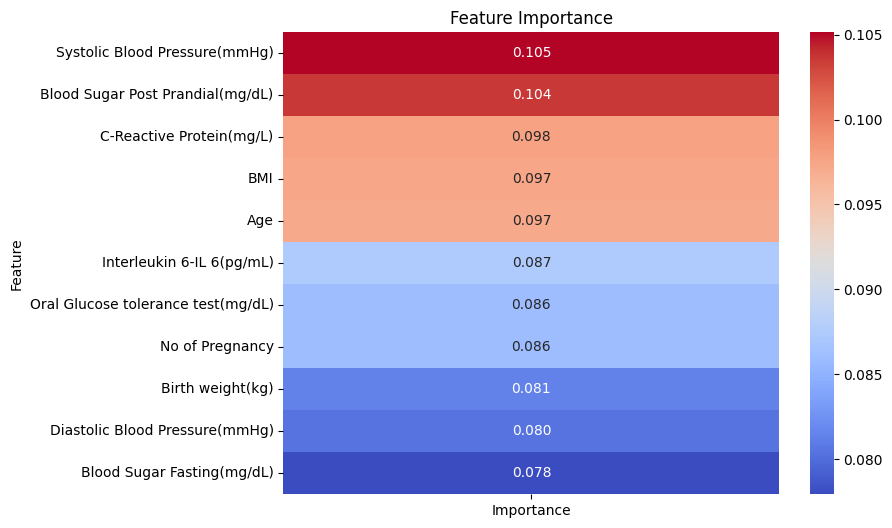

Final Accuracy: 0.9781203381402287
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3987
           1       1.00      0.96      0.98      4057

    accuracy                           0.98      8044
   macro avg       0.98      0.98      0.98      8044
weighted avg       0.98      0.98      0.98      8044



In [4]:
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv('balanced_dataset.csv')

X = data.drop(columns=['Preterm Pregnancy'])
y = data['Preterm Pregnancy']

fixed_params = {
    "n_d": 25,
    "n_a": 22,
    "n_steps": 6,
    "gamma": 0.3656150938326871,
    "momentum": 0.0816254305857589,
    "lambda_sparse": 0.05103010863006034,
    "optimizer_params": {
        "lr": 0.0018506127775402865,
        "weight_decay": 5.376118014372652e-05
    },
    "mask_type": "entmax",
}


model = TabNetClassifier(**fixed_params)

model.fit(X.values, y.values, eval_set=[(X.values, y.values)],
          eval_name=['train'], eval_metric=['accuracy'],
          max_epochs=200,
          batch_size=128, virtual_batch_size=32, num_workers=0, drop_last=False,
          patience=-1)

feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(feature_importance_df.set_index('Feature'), cmap='coolwarm', annot=True, fmt=".3f")
plt.title('Feature Importance')
plt.show()

y_pred = model.predict(X.values)

final_accuracy = accuracy_score(y, y_pred)
print("Final Accuracy:", final_accuracy)


class_report = classification_report(y, y_pred)
print("Classification Report:")
print(class_report)


In [ ]:
import pandas as pd

data = pd.read_csv('balanced_dataset.csv')

yes_instances = data[data['Preterm Pregnancy'] == 1]

contributing_ranges = {}

for feature in data.columns[:-1]:
    yes_25th_percentile = yes_instances[feature].quantile(0.25)
    yes_75th_percentile = yes_instances[feature].quantile(0.75)

    contributing_ranges[feature] = (yes_25th_percentile, yes_75th_percentile)
print("Most Contributing Ranges of Each Feature Towards Outcome 1:")
for feature, range_values in contributing_ranges.items():
    print(f"{feature}: Range {range_values[0]:.2f} - {range_values[1]:.2f}")




Most Contributing Ranges of Each Feature Towards Outcome 1:
Age: Range 20.00 - 27.00
No of Pregnancy: Range 2.00 - 3.00
BMI: Range 16.95 - 23.87
Systolic Blood Pressure(mmHg): Range 109.00 - 143.00
Diastolic Blood Pressure(mmHg): Range 67.00 - 91.00
Blood Sugar Fasting(mg/dL): Range 73.48 - 94.79
Blood Sugar Post Prandial(mg/dL): Range 132.11 - 174.58
Oral Glucose tolerance test(mg/dL): Range 118.38 - 155.68
C-Reactive Protein(mg/L): Range 12.98 - 19.11
Interleukin 6-IL 6(pg/mL): Range 5.56 - 9.52
Birth weight(kg): Range 1.95 - 2.92
